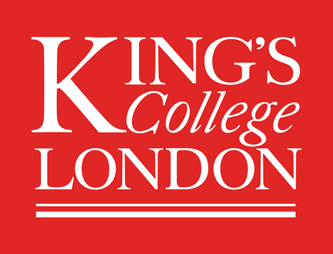

## King's College London
---

## MSc Individual Project 

### Short-Term Effects on FX Market in Response to US Macroeconomic Data Releases

---

**Course Title**: Computational Finance MSc

**Module Code**: 7CCSMPRJ 

**Supervisor**: Dr Teresa Yu Bi 

**Student's Full Name**: Edmond Osmena

**Student ID**: K24034176

**Candidate Number**: AF15292

----------------------

---


# <span style="color:blue"> Table of Contents </span>
1. [**Libraries**](#Libraries)  
2. [**Functions**](#Functions)  
    2.1 [Data Collection](#DataCollection)  
    2.2 [Data Preprocessing ](#DataPreprocessing)  
    2.3 [Feature Engineering](#FeatureEngineering)  
    2.4 [Plotting](#PlottingFunctions)  
    2.5 [Data Analysis](#DataAnalysis)  
3. [**Macro Data**](#MacroData)  
    3.1 [Macro Data Preprocessing](#MacroDataProcessing)   
    3.2 [Macro Data Seasonality](#MacroDataSeasonality)  
    3.3 [Macro Data Stats](#MacroDataStats)  
    3.4 [Macro Events Distribution](#MacroEventsDistribution )  
4. [**Final DataFrame**](#FinalDF)  
    4.1 [Merge FX Pair DFs with Macro Data DF](#MergeDFs)   
    4.2 [Extract Event Centric Data](#ExtractEventCentricData)   
    4.3 [Most Volatile timeframe on Event](#MostVolatileTimeframe)   
5. [**Macro Event Influence on FX Markets: A Quant Perspective**](#AQuantProspective)   
    5.1 [Volatility Importance: Top Macroeconomic Drivers](#TopMacroeconomicDrivers)    
    5.2 [Volatility Importance: Prior vs Now](#MacroVolatilityPriorNow)   
    5.3 [Short-Term Volatility Snapshot by Pair and Year](#ShortTermVolatility)    
    5.4 [Intraday Volatility & Return Trends Around Macro Events](#BeforeOnAfter)  
    5.5 [Summary Metrics of Market Reaction to Macro Events](#MacroVolatilitySummary)    
    5.6 [Macro Events Analyst Predictions vs Actual Outcomes](#AnalystsExpectationsActuals)  
    5.7 [Interdependence Between FX Pairs](#PairsCorrelation)   
6. [**Event Lower and Upper Bounds**](#EventBounds)   
7. [**Prediction Algorithms**](#PredictionAlgorithms)   
    7.1 [GARCH(1,1)](#GARCH(1,1))    
    7.2 [LSTM](#LSTM)  
         7.2.1 [LSTM Implementation](#LSTMImplementation)  
         7.2.2 [LSTM training & validation for all pairs across all events ](#LSTMTrainValidation)  
         7.2.3 [LSTM Plotting Actual vs Predictions](#LSTMActualVSPredictions)  
8. [**Evaluation Algorithms**](#EvaluationAlgorithms)  
    8.1 [MC Bounds Evaluation](#MCBounds)   
    8.2 [Compute KPIs](#ComputeKPIs)   
    8.3 [GARCH KPIs Evaluation](#GARCHEvaluation)   
    8.4 [LSTM KPIs Evaluation](#LSTMEvaluation)   
9. [**KPI Metrics Results**](#KPIsResults)  
    9.1 [Bounds test results](#MCBoundsResults)   
    9.2 [GARCH & LSTM Evaluation Results](#GARCHandLSTMKPIS)   
10. [**Single Event Predictions**](#SingleEventPredictions)  
    10.1 [LSTM Price Prediction](#LSTMSingleEvent)   
    10.2 [MC Bounds, GARCH and LSTM Predictions](#MCGARCHLSTM)  
    10.3 [Event Inputs](#EventInputs)  
    10.4 [Forecasting Results ](#ForecastingResults)  

----------------------

----------------------

# <span style="color:blue">1. Libraries</span> <a id="Libraries"></a>

In [1]:
# Libraries for data fetching
from polygon import RESTClient

# Libraries for data analysis
import pandas as pd
import numpy as np
import math
from IPython.display import display

# Libraries for plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.ticker import MaxNLocator
import seaborn as sns

# Libraries for time handling and warnings
import time  
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Libraries for statistical modeling
from arch import arch_model
from scipy.stats import jarque_bera

# Libraries for feature important, splitting, normalizing data and KPIs (metrics)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Libraries for ANN
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import backend as K

----------------------

----------------------

# <span style="color:blue">2. Functions</span> <a id="Functions"></a>


### <span style="color:blue">2.1 Data Collection </span> <a id="DataCollection"></a>
In this section, data collection of FX price (and other features) from Polygon.io (through API requests) and macroeconomic event data from the Bloomberg Terminal of KCL (the data was downloaded to a CSV which is being read within the code snippet below). 

* Data Collection FX pair tickers (symbols) for **Polygon.io**:
    * **USD/EUR** 🠆 C:USD/EUR
    * **USD/GBP** 🠆 C:USD/GBP
    * **USD/CNY** 🠆 C:USD/CHF  
    
* Macroeconomic events **Bloomberg Terminal (KCL)** (macro_data_bloomberg.csv):
    * **INTR** (every 6-weeks)
    * **CPI** (MoM)
    * **GDP** (QoQ)
    * **PCE** (MoM)
    * **UNRATE** (MoM)
    * **PMI** (MoM)

In [2]:
def polygon_get_fx_data(fx_pair, interval, start_date, end_date, api_key='0GbCWQKVtPfEMJvPmc1n50psE3zsW1c8'):
    """
    Retrieve historical FX data from Polygon.io.

    Parameters:
    - interval (str): The interval for the data ('1m', '5m', '1h', '1d').
    - start_date (str): The start date in 'YYYY-MM-DD' format.
    - end_date (str): The end date in 'YYYY-MM-DD' format.
    - api_key (str): Polygon.io API key.

    Returns:
    - pd.DataFrame: A DataFrame containing historical USD/CNY forex data.
    """
    try:
        # Bring the fx pair ticker to Polygon's format
        fx_pair_polygon_formated = "C:" + str(fx_pair)

        client = RESTClient(api_key)

        # Request data
        data_request = client.get_aggs(
            ticker=fx_pair_polygon_formated, 
            multiplier=1, 
            timespan=interval,
            from_=start_date, 
            to=end_date
        )
    
        # Convert response to DataFrame
        df = pd.DataFrame(data_request)
        
        # Check if data is returned
        if df.empty:
            print("No data found.")
            return None

        # Convert timestamp to datetime format and set Datetime as an index
        df["Datetime"] = pd.to_datetime(df["timestamp"], unit="ms")
        df.set_index("Datetime", inplace=True)
        
        # Drop columns not needed
        df = df.drop(columns=["otc", "transactions", "timestamp"])
        
        # Rename columns to align with yf for the feature engineering and merging later on
        df = df.rename(columns={"high": "High", "low": "Low", "close": "Adj Close", "volume": "Volume"})
        df = df.rename_axis(f'{fx_pair}', axis=1)
        
        return df

    except Exception as e:
        print(f"An error occurred: {e}")
        return None
        
        
def fetch_and_combine_fx_data(macro_df, pair):
    """
    Fetches and combines minute-level FX data for a given pair and list of macro event dates.

    Parameters:
    - macro_df: DataFrame with datetime index representing macro event dates.
    - pair: FX pair symbol (e.g. 'USD/EUR').

    Returns:
    - Combined DataFrame with volatility and price metrics, prefixed by pair.
    """
    # Get index values to list
    macro_dates_list = macro_df.index.strftime("%Y-%m-%d").tolist()
    
    # Initialize empty DataFrame
    data_df = pd.DataFrame()  

    for i, date in enumerate(macro_dates_list):
        fx_data = calculate_volatility(polygon_get_fx_data(pair, "minute", date, date))
        
        # Add pair symbol as a prefix to columns (excluding Datetime)
        fx_data = fx_data.rename(columns={col: f"{pair}_{col}" for col in fx_data.columns if col != "Datetime"})
        
        # Append the retrieved data to the main DataFrame
        data_df = pd.concat([data_df, fx_data])

        # Implement sleep logic for API limitations
        if (i + 1) % 5 == 0:  
            time.sleep(70)
        else:
            time.sleep(2) 

    return data_df


# Read the CSV file retrieved from Bloomberg Terminal        
macro_df = pd.read_csv("data/macro_bloomberg_data.csv")

### <span style="color:blue">2.2 Data Preprocessing</span> <a id="DataPreprocessing"></a>
This section covers data preprocessing steps to clean and standardize macroeconomic and FX data. It includes handling missing values, fixing inconsistent date formats, converting percentages, renaming event labels, and aligning FX data around each macro event. These steps ensure the dataset is consistent, complete, and ready for analysis before modeling.

In [3]:
def handle_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """ 
    Finds for  '--' values and converts them to NaN. 
    Afterwards, drop rows where Expected and Actual are NaN.
    
    Parameters:
    - df ()
    """
    # Missing values convert from '--' to NaN
    df.replace('--', np.nan, inplace=True)

    # Drop rows where Expected and Actual are missing
    df = macro_df.dropna(subset=["Expected", "Actual"], how="all")
    
    return df



def standardize_datetime_format(df: pd.DataFrame, column_name="Date Time") -> pd.DataFrame:
    """
    Standardizes the Date Time column to the format MM/DD/YYYY HH:MM,
    converts it to a datetime datatype, sets it as the index, and sorts the DataFrame.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the column to be formatted.
    - column_name (str): The name of the column to standardize.

    Returns:
    - pd.DataFrame: The DataFrame with the standardized datetime format, 
                    set as index, and sorted.
    """
    def fix_date_format(date_str):
        # Try parsing with two-digit year format first
        dt = pd.to_datetime(date_str, format='%m/%d/%y %H:%M', errors='coerce')
        
        # If conversion fails, try four-digit year format
        if pd.isnull(dt):
            dt = pd.to_datetime(date_str, format='%m/%d/%Y %H:%M', errors='coerce')
        
        return dt  # Return as datetime object

    # Apply the function to convert to datetime
    df = df.copy(deep=True)
    df["Datetime"] = df[column_name].astype(str).apply(fix_date_format)
    
    # Drop rows where conversion failed
    df = df.dropna(subset=["Datetime"])
    # Drop previous 'Date Time'
    df.drop(columns=['Date Time'], inplace=True)

    # Convert the column to datetime dtype
    df["Datetime"] = pd.to_datetime(df["Datetime"])

    # Set Date Time as index
    df = df.set_index("Datetime")

    # Sort DataFrame by the Date Time index
    df = df.sort_index()

    return df



def convert_percentage_to_numeric(df: pd.DataFrame, columns=["Expected", "Actual", "Prior"]) -> pd.DataFrame:
    """
    Converts percentage values in specified columns to numerical float values.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing percentage values.
    - columns (list): List of column names to convert.

    Returns:
    - pd.DataFrame: DataFrame with percentage values converted to floats.
    """
    for col in columns:
        df[col] = df[col].astype(str).str.replace('%', '', regex=True).astype(float)
    
    return df



def clean_macro_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Drops the 'Event' column and renames 'Ticker' values to standardized names.

    Parameters:
    - df (pd.DataFrame): The macroeconomic DataFrame.

    Returns:
    - pd.DataFrame: Cleaned DataFrame with renamed tickers.
    """
    
    # Drop the 'Event' column
    df = df.drop(columns=["Event"], errors="ignore")

    # Dictionary mapping for renaming
    ticker_mapping = {
        "UNRATE": "UNRATE",
        "CPI_MoM": "CPI",
        "INTR": "INTR",
        "PCE_MoM": "PCE",
        "GDP_QoQ": "GDP",
        "PMI": "PMI"
    }

    # Rename cols
    df["Ticker"] = df["Ticker"].replace(ticker_mapping)

    return df


def extract_relevant_fx_data(fx_data, macro_df, start, end)-> pd.DataFrame:
    """
    Extracts FX data around each macro event within a specified time window.

    Parameters:
    - fx_data: DataFrame with datetime index containing FX price and volatility data.
    - macro_df: DataFrame with macro event times as index and event metadata.
    - start: Minutes before the event to include.
    - end: Minutes after the event to include.

    Returns:
    - Combined DataFrame of FX data with added macro event details.
    """
    extracted_data = []

    for event_time in macro_df.index:
        start_time = event_time - pd.Timedelta(minutes=start)
        end_time = event_time + pd.Timedelta(minutes=end)

        # Check if any timestamps in the range exist in fx_data
        available_times = fx_data.index[(fx_data.index >= start_time) & (fx_data.index <= end_time)]

        if available_times.empty:  
            continue  # Skip if no matching timestamps exist

        filtered_fx = fx_data.loc[available_times].copy()

        # Add event details from macro_df
        if event_time in macro_df.index:
            filtered_fx["Ticker"] = macro_df.loc[event_time, "Ticker"]
            filtered_fx["Expected"] = macro_df.loc[event_time, "Expected"]
            filtered_fx["Actual"] = macro_df.loc[event_time, "Actual"]
            filtered_fx["Prior"] = macro_df.loc[event_time, "Prior"]
            filtered_fx["Surprise"] = macro_df.loc[event_time, "Surprise"]

        extracted_data.append(filtered_fx)

    # Set Datetime index
    final_df = pd.concat(extracted_data).reset_index()
    final_df = final_df.rename(columns={"index": "Datetime"}).set_index("Datetime")
    # Drop duplicates if they exist
    final_df = final_df[~final_df.index.duplicated(keep="first")]
    
    return final_df


def fill_in_missing_minute(dataframe: pd.DataFrame) -> pd.DataFrame:
    """
    Duplicates the row at `original_time`, changes its 'Datetime' to `new_time`, 
    appends it to the DataFrame, sorts by datetime, and resets the index.
    
    Parameters:
    - dataframe (pd.DataFrame): The input DataFrame with a 'Datetime' column.
    
    Returns:
    - pd.DataFrame: Updated DataFrame with the new row inserted and sorted by datetime.
    """
    df = dataframe.copy()
    df['Datetime'] = pd.to_datetime(df.index)

    # Locate the row to duplicate
    row_to_copy = df[df['Datetime'] == pd.to_datetime('2023-04-07 13:39:00')].copy()

    # Update datetime in the copied row
    row_to_copy.loc[:, 'Datetime'] = pd.to_datetime('2023-04-07 13:38:00')

    # Append and sort
    df = pd.concat([df, row_to_copy], ignore_index=True)
    df = df.sort_values(by='Datetime').reset_index(drop=True)
    
    # Set datetime as index
    df = df.set_index('Datetime')

    return df

### <span style="color:blue">2.3 Feature Engineering</span> <a id="FeatureEngineering"></a>
This section derives key features: the surprise (difference between actual and expected values) and volatility indicators to capture market reactions. These engineered features are essential for modeling FX behavior around macroeconomic events.

In [4]:
def surprise_calculation(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the surprise (difference) of Expected vs Actual.
    
    Parameters:
    - df (pd.DataFrame): macro economic data

    Returns:
    - pd.DataFrame: Original dataframe plus the surprise column.
    """
    
    df["Surprise"] = df["Actual"] - df["Expected"]
    return df


def calculate_volatility(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the average volatility dynamically.

    Parameters:
    - df (pd.DataFrame): FX data.

    Returns:
    - pd.DataFrame: The original DataFrame with added 'Volatility', 'Average_Volatility', and 'Volatility_Multiplier' columns.
    """

    if df is None or df.empty:
        print("Error: DataFrame is empty or invalid.")
        return None
    if "Adj Close" in df.columns:
        # Compute Volatility
        df['Volatility'] = np.abs(np.log(df['Adj Close'] / df['Adj Close'].shift(1)))
    else:
        df['Volatility'] = np.abs(np.log(df['Close'] / df['Close'].shift(1)))
        
    # Compute Average Volatility based on each trading day
    df['Average_Volatility'] = df['Volatility'].mean()
    # Compute Volatility Multiplier
    df['Volatility_Multiplier'] = round(df['Volatility'] / df['Average_Volatility'],2)

    return df

### <span style="color:blue">2.4 Plotting</span> <a id="PlottingFunctions"></a>
This section includes plotting functions used both for analyzing FX volatility patterns and macroeconomic impacts.
They also help visualize and compare model predictions (LSTM, GARCH, Lower and Upper Bounds) against actual prices.

In [5]:
########################################################################
################### Event Volatility Time Analysis #####################

def plot_time_differences(time_differences, avg_start, avg_end):
    """
    Plots histograms of the start and end time differences from the event time,
    highlighting the average start and end positions.

    Parameters:
    - time_differences (list of tuples): (start_diff, end_diff) per event.
    - avg_start (float): Average minutes before event start of volatility.
    - avg_end (float): Average minutes after event end of volatility.
    """
    start_diffs = [t[0] for t in time_differences]
    end_diffs = [t[1] for t in time_differences]
    plt.figure(figsize=(8, 6))
    
    # Plot histograms
    plt.hist(start_diffs, bins=25, alpha=0.6, color='blue', label='Start Time Difference', density=True)
    plt.hist(end_diffs, bins=25, alpha=0.6, color='red', label='End Time Difference', density=True)

    # Add KDE curves
    sns.kdeplot(start_diffs, color='blue')
    sns.kdeplot(end_diffs, color='red')

    # Add average time lines
    plt.axvline(0, color='black', linestyle='-', label='Event Time (0 min)')
    plt.axvline(avg_start, color='blue', linestyle='--', label=f'Avg Start ({avg_start} min)')
    plt.axvline(avg_end, color='red', linestyle='--', label=f'Avg End ({avg_end} min)')

    # Zoom in: focus on the main action zone
    plt.xlim(-100, 260)

    # Labels and style
    
    plt.title("Distribution of Most Volatile 16-Minute Timeframes")
    plt.xlabel("Time Difference from Event (minutes)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


###########################################################################
########################### Feature Importance ############################

def plot_event_importance(importance_df):
    """
    Plots the feature importance of macroeconomic events on Volatility.

    Args:
        importance_df (pd.DataFrame): Feature importance dataframe.
    """

    # Plot
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(data=importance_df, x="Volatility_Impact", y="Event", palette="Blues_r", dodge=False)
    for bar in ax.patches:
        bar.set_height(bar.get_height() * 0.7)
    
    plt.title("Feature Importance of Macroeconomic Events on Volatility", fontsize=12, fontweight='bold')
    plt.xlabel("Importance Score", fontsize=12)
    plt.ylabel("Event", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()

    plt.show()


def plot_event_importance_by_year(importance_df):
    """
    Plots the feature importance of macroeconomic events on Volatility across different years,
    sorted based on 2023 importance.

    Parameters:
    - importance_df (pd.DataFrame): Dataframe with feature importance scores per year.
    """

    # Define colors for each year
    color_palette = {2023: "#1f4b99", 2024: "#2a7ccc", 2025: "#87bfff"}  # Dark blue, blue, light blue

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.barplot(
        data=importance_df,
        x="Volatility_Impact",
        y="Event",
        hue="Year",
        palette=color_palette,
        ax=ax
    )

    # Plot customizations
    plt.title("Feature Importance of Macroeconomic Events on Volatility (2023-2025)", fontsize=12, fontweight='bold')
    plt.xlabel("Importance Score", fontsize=12)
    plt.ylabel("Event", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(title="Year", fontsize=10)
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()

    # Show plot
    plt.show()
    pass


###########################################################################
########################## Correlation Analysis ###########################

def analyze_usd_pairs_correlation(df, macro_df):
    """
    Analyze the correlation between USD pairs around macroeconomic event times.
    
    Parameters:
    - df (pd.DataFrame): FX market data with datetime index.
    - macro_df (pd.DataFrame): Macro event timestamps.
    
    Returns:
    - None, just a plot.
    """
    
    # Selecting only the AdjClose columns for the three currency pairs
    adj_close_data = final_data[['USDEUR_AdjClose', 'USDGBP_AdjClose', 'USDCNH_AdjClose']]

    # Drop any rows with null values
    adj_close_data = adj_close_data.dropna()

    # Compute correlation matrix
    corr_matrix = adj_close_data.corr()

    # Plot heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(corr_matrix, annot=True, cmap="Blues", fmt=".2f")
    plt.title("Correlation Heatmap - AdjClose of Currency Pairs", fontsize=12, fontweight='bold')
    plt.show()
    

###########################################################################
##################### Analysts Expectations vs Actual #####################

def plot_expectations_vs_actual(df: pd.DataFrame):
    # Ensure datetime format and event segmentation
    df = df.reset_index(drop=True)
    df['EventID'] = df.index // 16
    event_blocks = df.groupby('EventID').first()

    # Correctness of predictions
    event_blocks['CorrectPrediction'] = event_blocks['Expected'] == event_blocks['Actual']

    # Count correct and incorrect predictions per Ticker
    correct_counts = event_blocks[event_blocks['CorrectPrediction']].groupby('Ticker').size()
    incorrect_counts = event_blocks[~event_blocks['CorrectPrediction']].groupby('Ticker').size()

    # Fill missing tickers with 0
    all_tickers = set(event_blocks['Ticker'].unique())
    correct_counts = correct_counts.reindex(all_tickers, fill_value=0)
    incorrect_counts = incorrect_counts.reindex(all_tickers, fill_value=0)

    # Sort by correct prediction counts
    sorted_tickers = correct_counts.sort_values(ascending=False).index
    correct_counts = correct_counts[sorted_tickers]
    incorrect_counts = incorrect_counts[sorted_tickers]

    # Plot
    x = range(len(sorted_tickers))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 5))
    bars1 = ax.bar(x, correct_counts, width, label='Expected == Actual', color='#1f4b99')
    bars2 = ax.bar([i + width for i in x], incorrect_counts, width, label='Expected ≠ Actual', color='#87bfff')

    # Add value labels above bars
    for bar in bars1 + bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.2, str(int(height)),
                ha='center', va='bottom', fontsize=8)

    # Customize plot
    ax.set_xlabel('Macro Event Type', fontsize=10)
    ax.set_ylabel('Number of Events', fontsize=10)
    ax.set_title('Prediction Accuracy per Macro Event Type', fontsize=12, fontweight='bold')
    ax.set_xticks([i + width / 2 for i in x])
    ax.set_xticklabels(sorted_tickers, fontsize=9)
    ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))  # Force integer y-ticks
    ax.tick_params(axis='y', labelsize=9)
    ax.grid(False)  # Remove grid
    ax.legend(fontsize=9)  # Add legend
    plt.tight_layout(pad=1)
    plt.show()
    
    
###########################################################################
##################### Time_Window: Before, On, After ######################

def plot_fx_event_patterns(results_dict, fx_pairs):
    """
    Plots volatility and absolute return trends (Before, On, After) for each FX pair.

    Parameters:
    - results_dict: output from analyze_event_windows()
    - fx_pairs: list of FX pair keys (e.g. 'USDEUR_AdjClose')

    Displays 2 charts per FX pair: one for volatility, one for absolute return.
    """
    ordered_windows = ['Before', 'On', 'After']
    fig, axes = plt.subplots(len(fx_pairs), 2, figsize=(12, 8 ))

    for i, pair in enumerate(fx_pairs):
        df = results_dict[pair].copy()
        df['Time_Window'] = pd.Categorical(df['Time_Window'], categories=ordered_windows, ordered=True)
        grouped = df.groupby('Time_Window').mean(numeric_only=True)

        # Volatility trend
        axes[i, 0].plot(grouped.index, grouped['Average_Volatility'], marker='o', color='blue')
        axes[i, 0].set_title(f'{pair.replace("_AdjClose", "")}: Volatility Trend', fontweight='bold')
        axes[i, 0].set_ylabel('Volatility', fontweight='bold', color='blue')


        # Absolute return trend
        axes[i, 1].plot(grouped.index, grouped['Average_Absolute_Return'], marker='o', color='green')
        axes[i, 1].set_title(f'{pair.replace("_AdjClose", "")}: Absolute Return Trend', fontweight='bold')
        axes[i, 1].set_ylabel('Absolute Return', fontweight='bold', color='green')

    plt.tight_layout()
    plt.show()
    
    
###########################################################################
################# Short Term Volatility of Pair per Year ##################

def plot_short_term_vol_per_year(df: pd.DataFrame):
    """
    Plots a 3x3 grid of bar charts showing volatility summaries for 3 FX pairs across 3 years (2023–2025).

    Each bar chart displays:
    - '1-min': Volatility at 6th minute of each 16-minute event
    - '5-min': Max avg of rolling 5-min windows (1–5, 6–10, 11–15)
    - '16-min': Full average over the 16-minute event
    """
    
    # Add Year column
    df.index = pd.to_datetime(df.index, dayfirst=True)
    df['Year'] = df.index.year
    
    years = [2023, 2024, 2025]
    pairs = {
        'USDGBP': 'USDGBP_Volatility',
        'USDEUR': 'USDEUR_Volatility',
        'USDCNH': 'USDCNH_Volatility'
    }

    fig, axs = plt.subplots(3, 3, figsize=(12, 8))
    fig.subplots_adjust(hspace=0.4, wspace=0.3)

    for row_idx, (pair, col) in enumerate(pairs.items()):
        for col_idx, year in enumerate(years):
            data = df[df['Year'] == year][[col]].reset_index(drop=True)
            if len(data) < 16:
                continue

            one_min, five_min, full_avg = [], [], []
            num_events = len(data) // 16

            for i in range(num_events):
                block = data[col].iloc[i*16:(i+1)*16].reset_index(drop=True)
                if len(block) < 16:
                    continue

                one_min.append(block.iloc[5])
                rolling = [block.iloc[start:start+5].mean() for start in [0, 5, 10] if start + 5 <= len(block)]
                five_min.append(max(rolling) if rolling else np.nan)
                full_avg.append(block.mean())

            avg_vols = [np.mean(one_min), np.mean(five_min), np.mean(full_avg)]

            ax = axs[row_idx, col_idx]
            ax.bar(['1-min', '5-min', '16-min'], avg_vols, color="#1f4b88", width=0.33)
            ax.set_title(f'{pair} - {year}', fontsize=12, fontweight='bold')
            ax.tick_params(axis='x', labelsize=8)
            ax.tick_params(axis='y', labelsize=8)
            ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
            ax.grid(False)

    plt.tight_layout()
    plt.show()
    
    
###########################################################################
################# Distribution Analysis of Macro Events ###################
    
def plot_actual_distributions(df, value_col='Actual'):
    """
    Plot histograms with KDE lines for the distribution of a specified value column,
    grouped by a categorical column (e.g. macroeconomic event tickers).

    Parameters:
    - df: DataFrame containing the data
    - value_col: name of the column with numeric values (default 'Actual')
    - bins: number of histogram bins (default 20)
    """

    tickers = df['Ticker'].unique()
    num_tickers = len(tickers)
    cols = 2
    rows = int(np.ceil(num_tickers / cols))

    fig, axs = plt.subplots(rows, cols, figsize=(14, rows * 3.5))
    axs = axs.flatten()

    for i, ticker in enumerate(tickers):
        data = df[df['Ticker'] == ticker][value_col].dropna()
        sns.histplot(data, kde=True, ax=axs[i], bins=10, color='steelblue')

        # Enhance KDE line
        for line in axs[i].lines:
            line.set_linewidth(2.5)
            line.set_color('blue')

        axs[i].set_title(f'Distribution of {value_col} - {ticker}', fontsize=14, fontweight='bold')
        axs[i].set_xlabel(f'{value_col} Value')
        axs[i].set_ylabel('Observations')
        axs[i].grid(True)

    # Hide any extra axes
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()
    
    
###########################################################################
################ Subplots for 6 distinct events per pair ##################
    
def plot_one_of_each_event_all_pairs(results_dict):
    """
    Plot 6 unique macro events (1 of each type) across 3 FX pairs: 6 rows × 3 columns.
    
    Each row corresponds to a macro event type.
    Each column corresponds to an FX pair.
    """
    fx_pairs = ['USDEUR', 'USDGBP', 'USDCNH']
    event_types = ['CPI', 'GDP', 'INTR', 'PCE', 'PMI', 'UNRATE']
    
    fig, axes = plt.subplots(len(event_types), len(fx_pairs), figsize=(18, 15), sharex=True)

    for row, event_type in enumerate(event_types):
        for col, pair in enumerate(fx_pairs):
            ax = axes[row, col]
            pair_data = results_dict[pair]

            # Find the first index where event matches
            try:
                event_indices = [i for i, ev in enumerate(pair_data['events']) if ev == event_type]
                if not event_indices:
                    ax.set_visible(False)
                    continue
                idx = event_indices[0]

                pred_scaled = pair_data['preds'][idx]
                actual_scaled = pair_data['actuals'][idx]
                price_scaler = pair_data['price_scaler']

                # Already includes base + T0 to T10
                pred_real = price_scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()
                actual_real = price_scaler.inverse_transform(actual_scaled.reshape(-1, 1)).flatten()

                # Plot
                x_range = range(-1, 11)  # T-1 to T10
                ax.plot(x_range, actual_real, marker='o', label='Actual')
                ax.plot(x_range, pred_real, marker='x', label='Predicted')
                ax.axvline(0, linestyle='--', color='gray', label='Event Time')

                # Axis formatting
                y_min = min(actual_real.min(), pred_real.min())
                y_max = max(actual_real.max(), pred_real.max())
                buffer = 0.25 * (y_max - y_min)
                ax.set_ylim(y_min - buffer, y_max + buffer)

                if row == 0:
                    ax.set_title(pair, fontsize=12, fontweight='bold')
                if col == 0:
                    ax.set_ylabel(event_type, fontsize=12, fontweight='bold')

                if row == 0 and col == 0:
                    ax.legend(fontsize=8)

                ax.tick_params(labelsize=9)
                ax.grid(False)
            except Exception as e:
                ax.set_visible(False)
                continue

    fig.suptitle("FX Forecasts by Event and Pair (T-1 to T+10)", fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0.02, 0.02, 0.95, 0.95])  # Adjust layout (more space)
    plt.subplots_adjust(hspace=0.4, wspace=0.1)      # More space between rows and columns
    plt.show()
    
    
###########################################################################
############# Event: Price prediction (Garch & LSTM) & Bounds ###############
    
def plot_fx_forecasts(df, actual_prices):
    """
    Plots LSTM, GARCH, and Monte Carlo bounds from the combined FX forecast DataFrame.

    Args:
        df (pd.DataFrame): Combined output from combine_fx_event_predictions
        actual_prices (list or np.array): Actual FX prices over the same timestamps
    """
    times = df.index
    lstm = df['LSTM_Price']
    garch = df['GARCH_Price']
    bounds = df['MC_Bounds'].apply(lambda x: x if isinstance(x, tuple) else (None, None))
    lower_bounds = bounds.apply(lambda x: x[0])
    upper_bounds = bounds.apply(lambda x: x[1])

    # Calculate y-axis limits with 5% adjustment (zoom out)
    all_prices = pd.concat([lstm, garch, pd.Series(actual_prices, index=times), lower_bounds, upper_bounds])
    min_y = all_prices.min()
    max_y = all_prices.max()
    y_padding = 0.1 * (max_y - min_y)
    y_lower = min_y - y_padding
    y_upper = max_y + y_padding

    # Plotting
    plt.figure(figsize=(13, 6))
    plt.plot(times, lstm, label='LSTM Forecast', color='blue', linestyle='--', linewidth=2)
    plt.plot(times, garch, label='GARCH Forecast', color='orange', linestyle='--', linewidth=2)
    plt.plot(times, actual_prices, label='Actual Price', color='black',  linewidth=2, marker='o', markersize=4)

    # Monte Carlo bounds as shaded region
    plt.fill_between(times, lower_bounds, upper_bounds, color='red', alpha=0.08, label='MC Bounds')

    # Draw vertical line at the same time as the first non-null MC_Bounds
    event_time_candidates = df[df['MC_Bounds'].apply(lambda x: isinstance(x, tuple) and x[0] is not None)].index

    if not event_time_candidates.empty:
        event_time = event_time_candidates[1]
        plt.axvline(x=event_time, color='black', linestyle=':', linewidth=2, label='Event Time')

    # Formatting
    fx_pair = df['FX_Pair'].iloc[0]
    event = df['Ticker'].iloc[0]
    plt.title(f"FX Forecast for {fx_pair} — Event: {event}", fontsize=16, weight='bold')
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("FX Price", fontsize=12)
    plt.ylim(y_lower, y_upper)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

### <span style="color:blue">2.5 Data Analysis</span> <a id="DataAnalysis"></a>
It analyzes how FX markets react to macroeconomic events. It identifies the most volatile timeframes, computes each event’s impact on volatility, and compares FX behaviour before, during, and after announcements. Additionally, key stats and summary tables help highlight patterns and event significance.

In [6]:
###########################################################################
######################## Most Volatile Timeframe ##########################

def find_most_volatile_16min(df, filtered_macro_df):
    """
    Finds the most volatile 16-minute timeframe for each event date in filtered_macro_df.

    Parameters:
        - df (pd.DataFrame): FX data with Datetime index.
        - filtered_macro_df (pd.DataFrame): Macro data with event timestamps as index.

    Returns:
        - dict: Most volatile timeframes for each event.
        - float: Average time difference for start and end times.
    """
    
    # Store results
    most_volatile_times = {}
    time_differences = []

    # Check if required volatility columns exist
    required_columns = ["USDEUR_Volatility", "USDGBP_Volatility", "USDCNH_Volatility"]
    
    # Compute combined average volatility
    df["Average_Volatility"] = df[required_columns].mean(axis=1)

    # Loop through each event in filtered_macro_df
    for event_date in filtered_macro_df.index:
        event_date = pd.to_datetime(event_date)

        # Filter only data for the event date
        group = df[df.index.date == event_date.date()]
        if group.empty: continue

        # Compute rolling sum of average volatility
        rolling_volatility = group["Average_Volatility"].rolling(window=7, min_periods=7).sum()
        # Get the time with the highest volatility over the exact 16-minute window
        end_time = rolling_volatility.idxmax()
        if pd.isna(end_time): continue
        start_time = end_time - timedelta(minutes=15)

        # Compute time difference from event timestamp. Convert to minutes
        diff_start = (start_time - event_date).total_seconds() / 60
        diff_end = (end_time - event_date).total_seconds() / 60

        # Store results
        most_volatile_times[event_date] = (start_time, end_time)
        time_differences.append((diff_start, diff_end))

    # Compute average time differences
    avg_diff_start = math.floor(np.mean([diff[0] for diff in time_differences]))
    avg_diff_end = math.floor(np.mean([diff[1] for diff in time_differences]))

    print(f"\nTotal events analyzed: {len(most_volatile_times)}")
    print(f"Average Time Difference: {avg_diff_start} min (start) | {avg_diff_end} min (end)")

    return most_volatile_times, avg_diff_start,  avg_diff_end, time_differences


###########################################################################
###################### Macro Data Event Importance ########################

def compute_event_importance(df):
    """
    Computes the importance of macroeconomic events on Volatility.

    Parameters:
    - df (pd.DataFrame): Dataset containing macro events and FX market data.

    Returns:
    - pd.DataFrame: Dataframe with feature importance scores.
    """

    # One-Hot Encode Event Types
    events = pd.get_dummies(df["Ticker"])  
    df = pd.concat([df, events], axis=1)

    # Define target variable (Volatility Impact)
    df["Volatility_Impact"] = df[["USDEUR_VolatilityMultiplier", 
                                  "USDGBP_VolatilityMultiplier", 
                                  "USDCNH_VolatilityMultiplier"]].mean(axis=1)

    # Features = Event Types
    X = df[events.columns]
    y_volatility = df["Volatility_Impact"]

    # Train Random Forest Regressor
    rf_volatility = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_volatility.fit(X, y_volatility)

    # Compute feature importance
    importance_df = pd.DataFrame({
        "Event": X.columns,
        "Volatility_Impact": rf_volatility.feature_importances_
    }).sort_values(by="Volatility_Impact", ascending=False)

    return importance_df


def compute_event_importance_by_year(df, years=[2023, 2024, 2025]):
    """
    Computes the importance of macroeconomic events on Volatility for specified years.

    Parameters:
    - df (pd.DataFrame): Dataset containing macro events and FX market data.
    - years (list): List of years to analyze.

    Returns:
    - pd.DataFrame: Dataframe with feature importance scores for each year.
    """

    importance_list = []

    for year in years:
        df_year = df[df.index.year == year].copy()

        if df_year.empty:
            continue

        # One-Hot Encode Event Types
        events = pd.get_dummies(df_year["Ticker"])  
        df_year = pd.concat([df_year, events], axis=1)

        # Define target variable (Volatility Impact)
        df_year["Volatility_Impact"] = df_year[["USDEUR_VolatilityMultiplier", "USDGBP_VolatilityMultiplier", "USDCNH_VolatilityMultiplier"]].mean(axis=1)

        # Define features (Event Types)
        X = df_year[events.columns]
        y_volatility = df_year["Volatility_Impact"]

        # Train Random Forest Regressor
        rf_volatility = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_volatility.fit(X, y_volatility)

        # Store feature importance
        importance_df = pd.DataFrame({
            "Event": X.columns,
            "Volatility_Impact": rf_volatility.feature_importances_,
            "Year": year
        })

        importance_list.append(importance_df)

    # Combine all years
    combined_importance = pd.concat(importance_list)

    # Sort by 2023 event importance
    sort_order = combined_importance[combined_importance["Year"] == 2024].sort_values(by="Volatility_Impact", ascending=False)["Event"]
    combined_importance["Event"] = pd.Categorical(combined_importance["Event"], categories=sort_order, ordered=True)

    return combined_importance

###########################################################################
################ Analysis Before, On and After the event ##################

def analyze_event_windows(df):
    """
    Analyzes return and volatility across 'Before', 'On', and 'After' windows 
    for each macro event and FX pair.

    Parameters:
    - df: DataFrame with macro-labeled FX data, 16 rows per event.

    Returns:
    - Dictionary of DataFrames, one per FX pair, with grouped stats by Event Type and Time Window.
    """
    df = df.reset_index(drop=True)

    # Assign unique event IDs and minute index within each event block
    df['EventID'] = df.index // 16
    df['MinuteIndex'] = df.groupby('EventID').cumcount()
    df['Event_Type'] = df.groupby('EventID')['Ticker'].transform('first')
    
    # Label time window based on minute index
    def window_label(i):
        if i <= 4:
            return 'Before'
        elif i == 5:
            return 'On'
        else:
            return 'After'

    df['Time_Window'] = df['MinuteIndex'].apply(window_label)

    fx_pairs = ['USDEUR_AdjClose', 'USDGBP_AdjClose', 'USDCNH_AdjClose']
    results = {}

    for pair in fx_pairs:
        return_col = f'{pair}_Return'
        vol_col = f'{pair.replace("AdjClose", "Volatility")}'

        # Calculate percentage returns per EventID
        df[return_col] = df.groupby('EventID')[pair].pct_change().fillna(0)

        # Calculate rolling volatility (standard deviation of returns) per EventID
        df[vol_col] = (
            df.groupby('EventID')[return_col]
            .rolling(window=5, min_periods=1)
            .std()
            .reset_index(level=0, drop=True)
            .fillna(0)
        )

        # Group and calculate return metrics
        returns = df.groupby(['Event_Type', 'Time_Window'])[return_col].agg(
            Minimum_Return='min',
            Maximum_Return='max',
            Average_Absolute_Return=lambda x: x.abs().mean()
        )

        # Group and calculate average volatility
        volatility = df.groupby(['Event_Type', 'Time_Window'])[vol_col].mean().to_frame(name='Average_Volatility')

        # Combine into one result per FX pair
        results[pair] = returns.join(volatility).reset_index()

    # Sort each FX pair's result by Event Type and ordered Time Window
    ordered_window = ['Before', 'On', 'After']
    for pair in results:
        df_pair = results[pair]
        df_pair['Time_Window'] = pd.Categorical(df_pair['Time_Window'], categories=ordered_window, ordered=True)
        results[pair] = df_pair.sort_values(['Event_Type', 'Time_Window']).reset_index(drop=True)

    return results


###########################################################################
################# Macro Events Volatility Summary Table ###################

def format_macro_summary_table(results_dict):
    """
    Builds a summary DataFrame with metrics similar to Screenshot 1 for each FX pair.

    Columns:
    - ANNOUNCEMENT (Event Type)
    - COUNTRY (inferred from event origin)
    - COEFF: average volatility 'On' (as proxy for impact)
    - ROB.T: t-statistic proxy = On / Before volatility (relative jump size)
    - %JUMP: percentage change in volatility from Before to On
    - %DAY: volatility share = On / (Before + After)
    """
    formatted_dfs = []

    for pair_name, df in results_dict.items():
        df = df.copy()
        pivoted = df.pivot(index='Event_Type', columns='Time_Window')

        # Extract relevant values
        on_vol = pivoted['Average_Volatility']['On']
        before_vol = pivoted['Average_Volatility']['Before']
        after_vol = pivoted['Average_Volatility']['After']

        # Calculated metrics
        coeff = on_vol
        rob_t = on_vol / before_vol
        pct_jump = 100 * (on_vol - before_vol) / before_vol
        pct_day = 100 * on_vol / (before_vol + after_vol)

        summary_df = pd.DataFrame({
            'PAIR': pair_name.replace('_AdjClose', ''),
            "COUNTRY": 'US',  # placeholder
            'EVENT': on_vol.index,
            'COEFF': round(coeff,5),
            'ROB.T': round(rob_t,2),
            '%JUMP': round(pct_jump,2),
            '%DAY': round(pct_day,2)
        }).reset_index(drop=True)

        formatted_dfs.append(summary_df)
    
    return pd.concat(formatted_dfs, ignore_index=True)

###########################################################################
#################### Macro Events Stats Computation #######################

def compute_grouped_actual_stats(df, value_col='Actual'):
    """
    Compute descriptive statistics (mean, median, std, Jarque-Bera, observations)
    for a numeric column grouped by Ticker.

    Significance stars (*** only) are shown for Jarque-Bera test if p-value < 0.01.

    Parameters:
    - df: DataFrame with macroeconomic event data
    - value_col: name of the numeric column to compute stats on

    Returns:
    - stats_df: formatted statistics table with Ticker columns and statistic rows
    """

    grouped = df.groupby('Ticker')[value_col]

    # Compute stats
    stats = {
        'Mean': grouped.mean(),
        'Median': grouped.median(),
        'SD': grouped.std(),
        'Jarque-Bera': grouped.apply(lambda x: jarque_bera(x.dropna())[0]),
        'JB p-value': pd.Series(0.01, index=grouped.groups.keys()),
        'Observations': grouped.count()
    }

    # Build DataFrame
    stats_df = pd.DataFrame(stats).T

    # Format Jarque-Bera row using fixed p-value
    stats_df.loc['Jarque-Bera'] = [
        f"{stats_df.loc['Jarque-Bera', col]:.2f}"
        for col in stats_df.columns
    ]

    # Drop JB p-value row since it's not needed
    stats_df = stats_df.drop(index='JB p-value')

    # Round numerical values
    for row in ['Mean', 'Median', 'SD']:
        stats_df.loc[row] = stats_df.loc[row].astype(float).round(2)

    # Ensure observation counts are integers
    stats_df.loc['Observations'] = stats_df.loc['Observations'].astype(int)

    # Sort by descending number of observations
    stats_df = stats_df.loc[:, stats_df.loc['Observations'].sort_values(ascending=False).index]

    return stats_df

----------------------

----------------------

# <span style="color:blue">3. Macro data</span> <a id="MacroData"></a>

### <span style="color:blue">3.1 Macro Data Preprocessing </span> <a id="MacroDataProcessing"></a>
Feature engineering and data preprocessing functions are applied to the macro data (collected from Bloomberg Terminal) to create a consinstense and complete macro dataframe

In [7]:
# Macroeconomics DataFrame
macro_df = clean_macro_dataframe(
                surprise_calculation(
                    convert_percentage_to_numeric(
                        standardize_datetime_format(
                            handle_missing_values(macro_df)
                        )
                   )
                )
           )

# Getting data for the past 2 years
filtered_macro_df = macro_df[macro_df.index >= "2023-03-10"].copy()
filtered_macro_df

,Ticker,Expected,Actual,Prior,Surprise
Datetime,,,,,
2023-03-10 13:30:00,UNRATE,3.4,3.6,3.40,0.2
2023-03-14 12:30:00,CPI,0.4,0.4,0.50,0.0
2023-03-22 18:00:00,INTR,5.0,5.0,4.75,0.0
2023-03-30 13:30:00,GDP,2.7,2.6,2.70,-0.1
2023-03-31 13:30:00,PCE,0.3,0.3,0.60,0.0
...,...,...,...,...,...
2025-01-29 19:00:00,INTR,4.5,4.5,4.50,0.0
2025-01-30 13:30:00,GDP,2.6,2.3,3.10,-0.3
2025-01-31 13:30:00,PCE,0.3,0.3,0.10,0.0


###  <span style="color:blue">3.2 Macro Data Seasonality </span> <a id="MacroDataSeasonality"></a>
It provides information (table) regarding the frequency of the selected macro data events

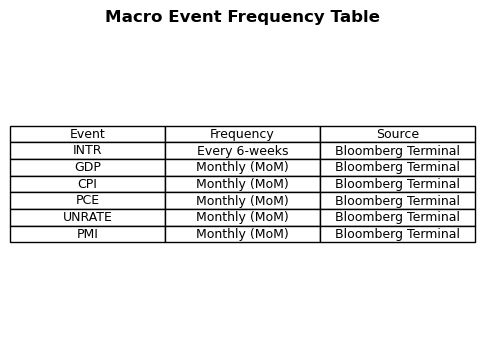

In [8]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.axis("tight")
ax.axis("off")
table_data = [["INTR", "Every 6-weeks", "Bloomberg Terminal"],
              ["GDP", "Monthly (MoM)", "Bloomberg Terminal"],
              ["CPI", "Monthly (MoM)", "Bloomberg Terminal"],
              ["PCE", "Monthly (MoM)", "Bloomberg Terminal"],
              ["UNRATE", "Monthly (MoM)", "Bloomberg Terminal"],
              ["PMI", "Monthly (MoM)", "Bloomberg Terminal"]]

table = ax.table(cellText=table_data, colLabels=["Event", "Frequency", "Source"], cellLoc="center", loc="center")

# Display the table
plt.title("Macro Event Frequency Table", fontsize=12, fontweight='bold')
plt.show()

###  <span style="color:blue">3.3 Macro Data Stats</span> <a id="MacroDataStats"></a>
Descriptive statistics that help summarize central tendencies and volatility across macroeconomic events. It also provides information regarding whether the data is normally distributed, and how many instances there are of each economic event (observations).

In [9]:
# Stats of Macro Events
compute_grouped_actual_stats(filtered_macro_df)

,CPI,UNRATE,GDP,PCE,PMI,INTR
Mean,0.25,3.86,2.72,0.2,49.46,5.23
Median,0.25,3.85,2.8,0.2,49.5,5.5
SD,0.17,0.25,1.13,0.13,1.52,0.37
Jarque-Bera,0.25,1.13,1.88,0.71,0.23,2.95
Observations,24,24,23,23,22,16


###  <span style="color:blue">3.4 Macro Events Distribution</span> <a id="MacroEventsDistribution"></a>
Distributions for each macro event are plotted to visualize event behavior, detect skewness, and review the shape of actual value frequencies.

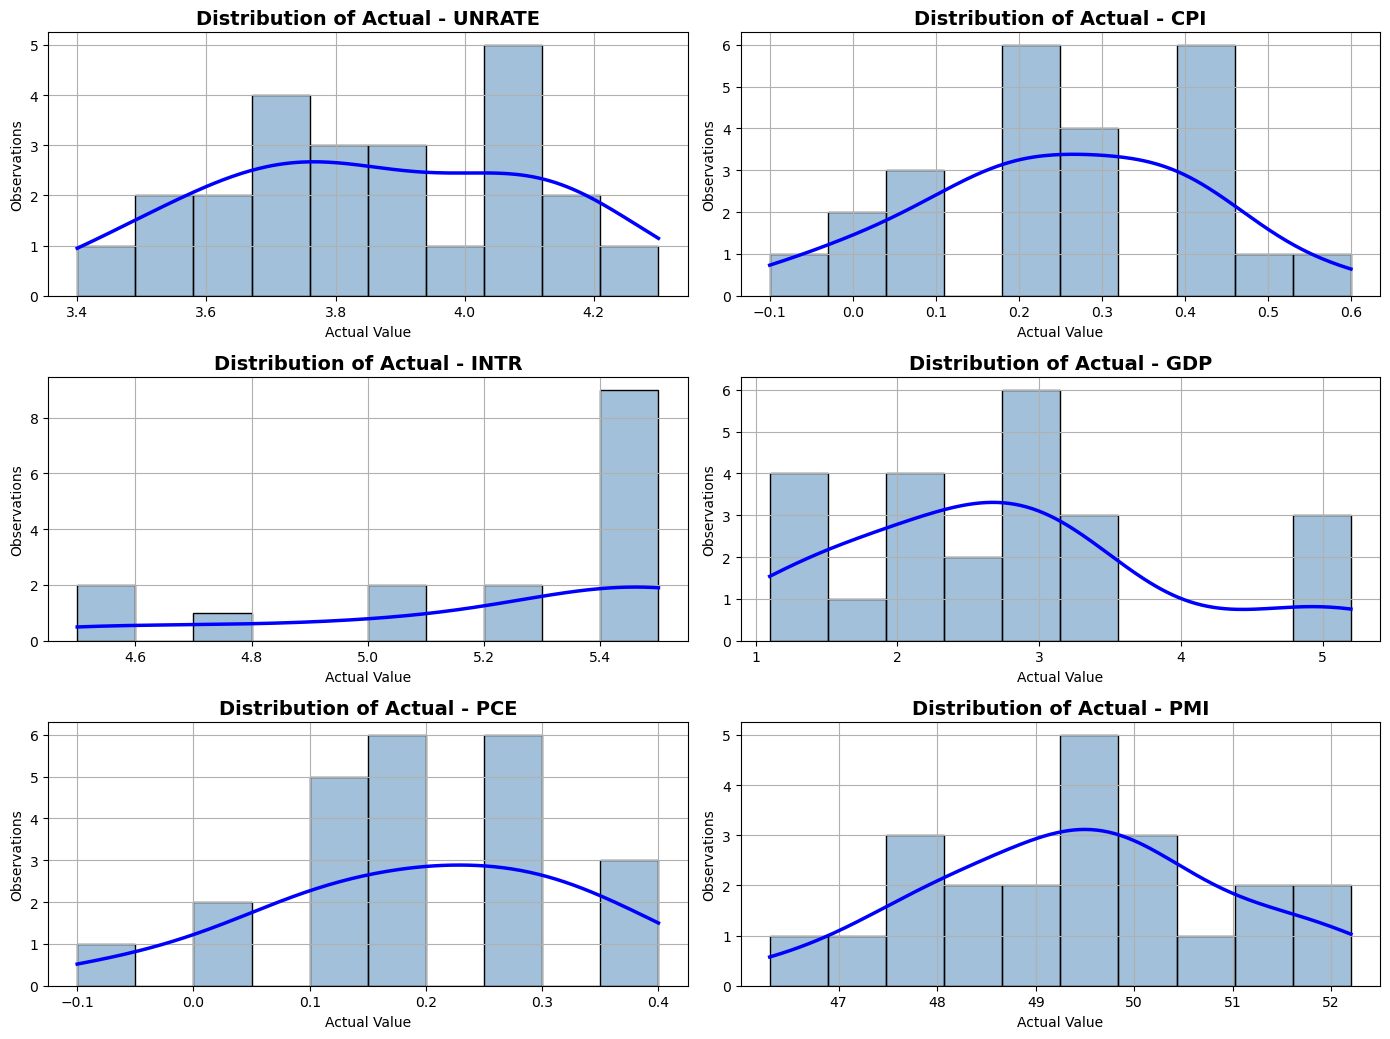

In [10]:
# Distribution plotting of Macro Events
plot_actual_distributions(filtered_macro_df)

----------------------

----------------------

#  <span style="color:blue">4. Final DataFrame </span> <a id="FinalDF"></a>

### <span style="color:blue">4.1 Merge FX Pair DFs with Macro Data DF</span> <a id="MergeDFs"></a>
FX data pairs are merged on a common timestamp to ensure synchronized event alignment. This dataframe contains all the data (00:00 - 23:59) for the macro economic event dates.

In [11]:
# This takes very long time as it retrieves data from Polygon which has a limitation of 5 requests per minute.
# Therefore the CSVs have been saved and everytime the code runs instead of running this function. 
# The code reads the CSVs from the 'Load CSVs' below.
# eur = fetch_and_combine_fx_data(filtered_macro_df, "USDEUR")
# gbp = fetch_and_combine_fx_data(filtered_macro_df, "USDGBP")
# cnh = fetch_and_combine_fx_data(filtered_macro_df, "USDCNH")

# Load CSVs
eur = pd.read_csv("data/USDEUR_data.csv")
gbp = pd.read_csv("data/USDGBP_data.csv")
cnh = pd.read_csv("data/USDCNH_data.csv")

for df in [eur, gbp, cnh]:
    df['Datetime'] = pd.to_datetime(df['Datetime'], dayfirst=True)
    df['Datetime'] = df['Datetime'].dt.strftime("%d/%m/%Y %H:%M")
    df.set_index('Datetime', inplace=True)
    
# Merge all three dataframes on 'Datetime' index, keeping only matching timestamps
merged_df = eur.merge(gbp, left_index=True, right_index=True, how="inner") \
               .merge(cnh, left_index=True, right_index=True, how="inner")

# Ensure the index is in datetime format
merged_df.index = pd.to_datetime(merged_df.index, format="%d/%m/%Y %H:%M")

# Sort the merged DataFrame by 'Datetime' index
merged_df.sort_index(inplace=True)

# Merged DataFrame before the filtering out all datetimes except for the most volatile time around the event
merged_df

,USDEUR_High,USDEUR_Low,USDEUR_AdjClose,USDEUR_Volume,USDEUR_vwap,USDEUR_Volatility,USDEUR_AverageVolatility,USDEUR_VolatilityMultiplier,USDGBP_High,USDGBP_Low,...,USDGBP_AverageVolatility,USDGBP_VolatilityMultiplier,USDCNH_High,USDCNH_Low,USDCNH_AdjClose,USDCNH_Volume,USDCNH_vwap,USDCNH_Volatility,USDCNH_AverageVolatility,USDCNH_VolatilityMultiplier
Datetime,,,,,,,,,,,,,,,,,,,,,
2023-03-10 00:00:00,0.94466,0.9443,0.94459,55,0.9446,NaN,0.000144,NaN,0.83872,0.838490,...,0.000156,NaN,6.97835,6.97635,6.97751,169,6.9776,NaN,0.000106,NaN
2023-03-10 00:01:00,0.94464,0.9444,0.94457,71,0.9446,0.000021,0.000144,0.15,0.83887,0.838620,...,0.000156,1.15,6.97814,6.97672,6.97749,109,6.9775,0.000003,0.000106,0.03
2023-03-10 00:02:00,0.94461,0.9444,0.94448,84,0.9445,0.000095,0.000144,0.66,0.83890,0.838560,...,0.000156,0.38,6.97801,6.97646,6.97784,121,6.9775,0.000050,0.000106,0.48
2023-03-10 00:03:00,0.94452,0.9443,0.94430,67,0.9445,0.000191,0.000144,1.33,0.83881,0.838590,...,0.000156,0.54,6.97786,6.97586,6.97711,103,6.9770,0.000105,0.000106,0.99
2023-03-10 00:04:00,0.94439,0.9441,0.94427,60,0.9443,0.000032,0.000144,0.22,0.83870,0.838480,...,0.000156,0.54,6.97776,6.97593,6.97659,86,6.9768,0.000074,0.000106,0.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-12 23:55:00,0.96238,0.9621,0.96220,32,0.9623,0.000187,0.000109,1.71,0.80330,0.803110,...,0.000112,0.78,7.31005,7.30872,7.30991,12,7.3097,0.000008,0.000050,0.16
2025-02-12 23:56:00,0.96231,0.9620,0.96220,30,0.9623,0.000000,0.000109,0.00,0.80318,0.803148,...,0.000112,0.00,7.31003,7.30874,7.30987,14,7.3098,0.000005,0.000050,0.11
2025-02-12 23:57:00,0.96231,0.9621,0.96220,41,0.9623,0.000000,0.000109,0.00,0.80319,0.803140,...,0.000112,0.00,7.30982,7.30860,7.30974,13,7.3095,0.000018,0.000050,0.35


### <span style="color:blue">4.2 Extract Event Centric Data </span> <a id="ExtractEventCentricData"></a>
From the merged data, the most relevant time window around each macro event is extracted (analysis has occured in section 4.3). Additional features like log returns are computed to support volatility and predictive modeling.

In [12]:
# FX data extracted based on the analysis above
fx_data = extract_relevant_fx_data(merged_df, macro_df, 5, 10)

# Final dataframe after event time analysis
final_data = fill_in_missing_minute(fx_data)

# Compute log returns for each FX pair
for pair in ['USDEUR', 'USDGBP', 'USDCNH']:
    price_col = f"{pair}_AdjClose"
    final_data[f"{pair}_log_return"] = np.log(final_data[price_col]) - np.log(final_data[price_col].shift(1))

final_data

,USDEUR_High,USDEUR_Low,USDEUR_AdjClose,USDEUR_Volume,USDEUR_vwap,USDEUR_Volatility,USDEUR_AverageVolatility,USDEUR_VolatilityMultiplier,USDGBP_High,USDGBP_Low,...,USDCNH_AverageVolatility,USDCNH_VolatilityMultiplier,Ticker,Expected,Actual,Prior,Surprise,USDEUR_log_return,USDGBP_log_return,USDCNH_log_return
Datetime,,,,,,,,,,,,,,,,,,,,,
2023-03-10 13:25:00,0.94447,0.943841,0.94436,149,0.9442,0.000169,0.000144,1.18,0.83399,0.83356,...,0.000106,1.73,UNRATE,3.4,3.6,3.4,0.2,NaN,NaN,NaN
2023-03-10 13:26:00,0.94442,0.944000,0.94417,117,0.9443,0.000201,0.000144,1.40,0.83392,0.83360,...,0.000106,1.28,UNRATE,3.4,3.6,3.4,0.2,-0.000201,-0.000132,-0.000135
2023-03-10 13:27:00,0.94425,0.943800,0.94425,115,0.9441,0.000085,0.000144,0.59,0.83398,0.83357,...,0.000106,0.42,UNRATE,3.4,3.6,3.4,0.2,0.000085,0.000099,-0.000045
2023-03-10 13:28:00,0.94431,0.943931,0.94428,165,0.9442,0.000032,0.000144,0.22,0.83420,0.83370,...,0.000106,2.90,UNRATE,3.4,3.6,3.4,0.2,0.000032,0.000273,-0.000306
2023-03-10 13:29:00,0.94429,0.943900,0.94410,197,0.9441,0.000191,0.000144,1.33,0.83413,0.83283,...,0.000106,0.22,UNRATE,3.4,3.6,3.4,0.2,-0.000191,-0.000456,-0.000023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-12 13:36:00,0.96915,0.968220,0.96859,192,0.9687,0.000341,0.000109,3.12,0.80751,0.80701,...,0.000050,3.67,CPI,0.3,0.5,0.4,0.2,-0.000341,-0.000099,-0.000184
2025-02-12 13:37:00,0.96893,0.968300,0.96872,176,0.9687,0.000134,0.000109,1.23,0.80760,0.80723,...,0.000050,1.69,CPI,0.3,0.5,0.4,0.2,0.000134,0.000198,0.000085
2025-02-12 13:38:00,0.96873,0.968060,0.96828,195,0.9683,0.000454,0.000109,4.16,0.80757,0.80696,...,0.000050,3.21,CPI,0.3,0.5,0.4,0.2,-0.000454,-0.000347,-0.000161


### <span style="color:blue"> 4.3 Most Volatile timeframe on Event </span> <a id="MostVolatileTimeframe"></a>
This section identifies the 16-minute period with the highest volatility around each macro event. On average, volatility peaks from 5 minutes before to 10 minutes after the event time (5 minutes before the event, on event, and 10 minutes after event seems to be the most volatile timeframe). 


Total events analyzed: 130
Average Time Difference: -5 min (start) | 10 min (end)


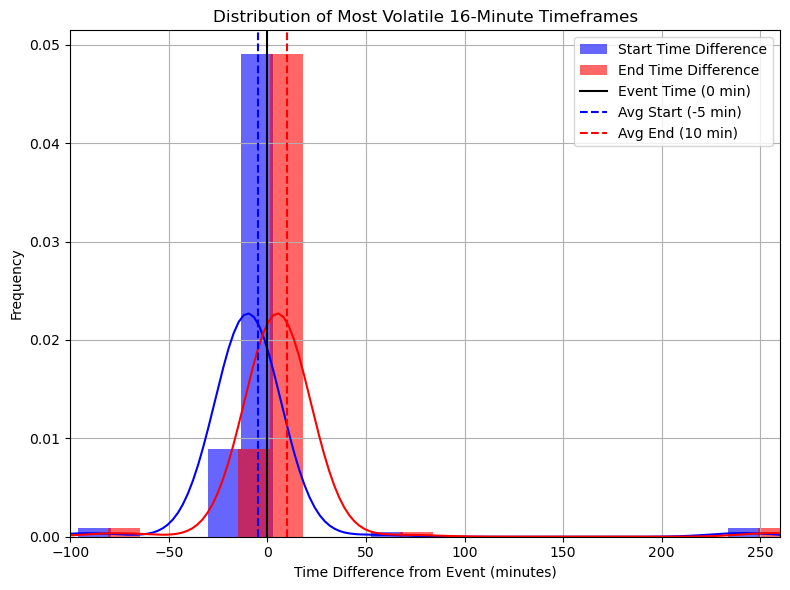

In [13]:
# Run the function
most_volatile_times, avg_start, avg_end, time_differences = find_most_volatile_16min(final_data, filtered_macro_df)

# Plot of most volatile timeframe
plot_time_differences(time_differences, avg_start, avg_end)

----------------------

------------

#  <span style="color:blue">5. Macro Event Influence on FX Markets: A Quant Perspective </span> <a id="AQuantProspective"></a>

###  <span style="color:blue">5.1 Volatility Importance: Top Macroeconomic Drivers </span> <a id="TopMacroeconomicDrivers"></a>
Macroeconomic events ranking by their average impact on FX volatility using a Random Forest model. UNRATE, INTR, and CPI are shown to be the most influential on market movements while GDP, PCE and PMI are moving the markets too but not with the same velocity.

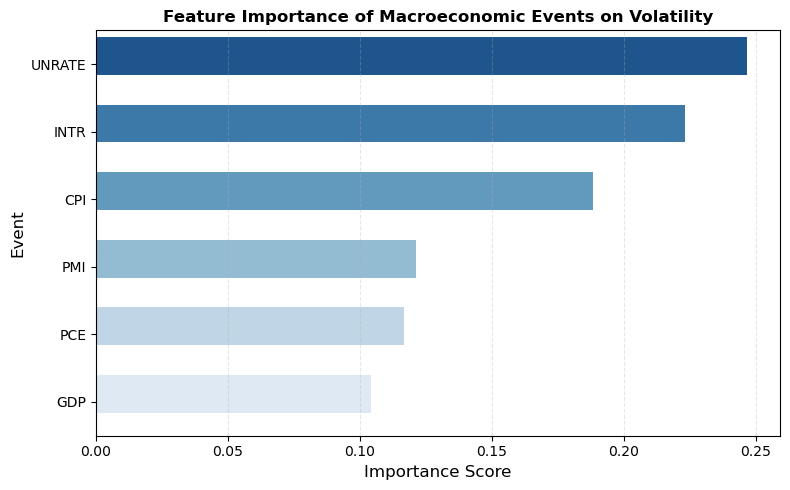

In [14]:
# Compute Event Importance based on Volatility
importance_results = compute_event_importance(final_data)

# Plot the events with their importance
plot_event_importance(importance_results)

### <span style="color:blue">5.2 Volatility Importance: Prior vs Now </span> <a id="MacroVolatilityPriorNow"></a>
Year-wise breakdown highlights how the importance of macro events changes over time. The 2025 year should not taken completely into consideration as there was data collected up to Q1 (1st quarter of the year).

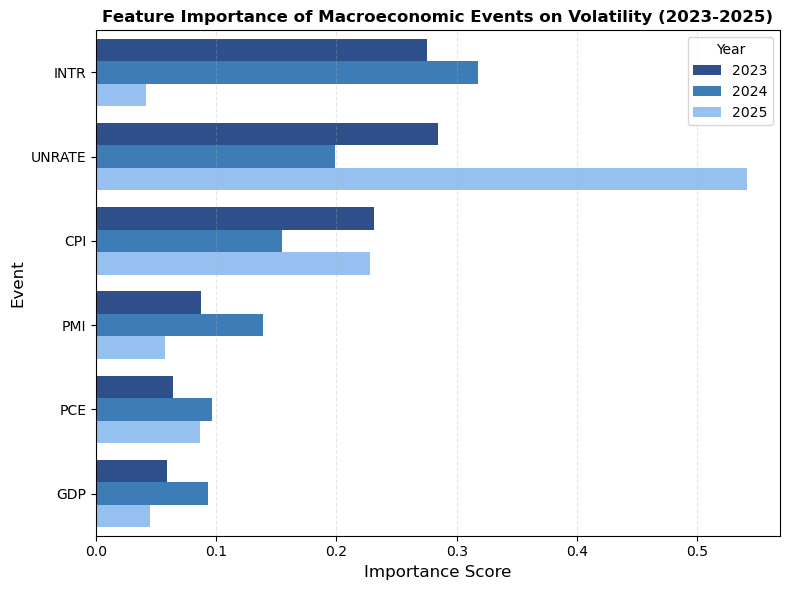

In [15]:
# Macro Data Event importance by year (2023-2025)
importance_results = compute_event_importance_by_year(final_data, years=[2023, 2024, 2025])

# Plot the results
plot_event_importance_by_year(importance_results)

### <span style="color:blue">5.3 Short-Term Volatility Snapshot by Pair and Year </span> <a id="ShortTermVolatility"></a>
This visual compares short-term volatility (1-min, 5-min, 16-min windows) for the pairs across 2023–2025. Volatility is highest at 1-minute intervals, indicating increased short-term market sensitivity.

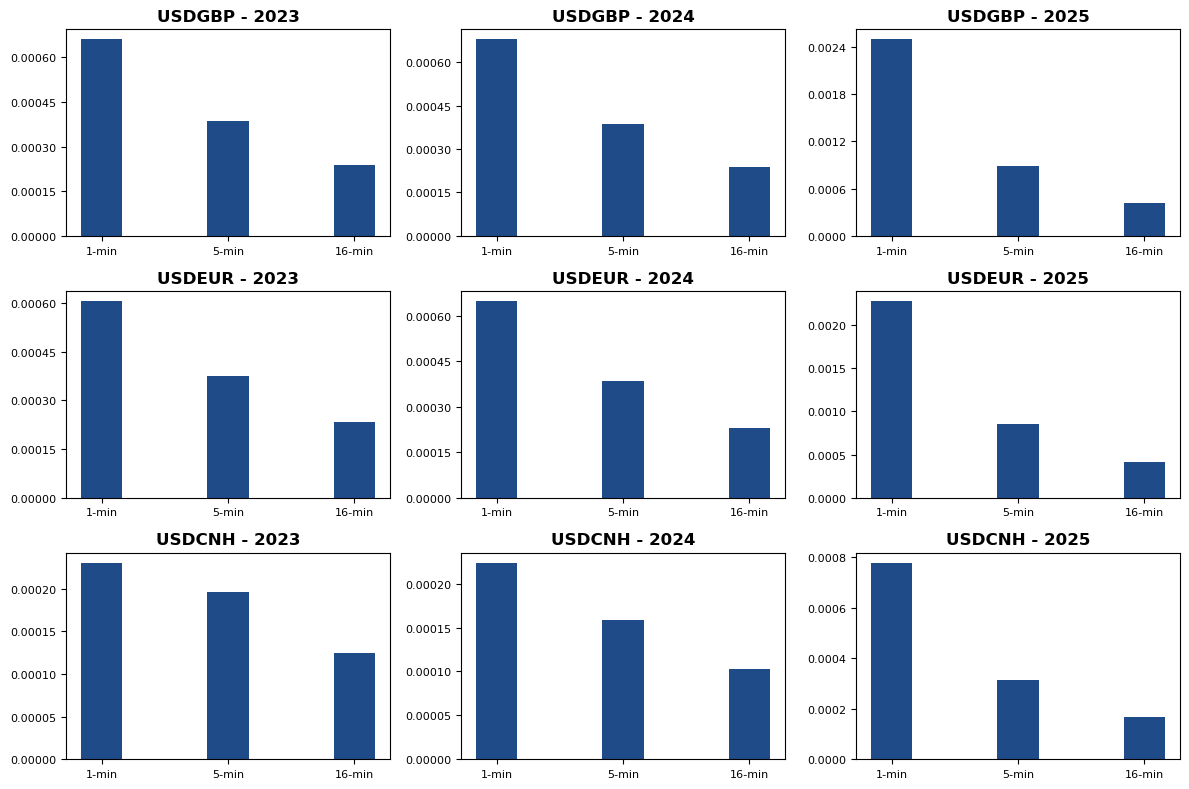

In [16]:
# Short Term Volatility of Pairs per Year
plot_short_term_vol_per_year(final_data)

### </span> <span style="color:blue">5.4 Intraday Volatility & Return Trends Around Macro Events </span>  <a id="BeforeOnAfter"></a>
This section displays information about return and volatility trends before, on and after the event. Notably, on event there is the highest absolut returns and volatility too.

In [17]:
# Run the analysis and get individual DataFrames
fx_analysis_results = analyze_event_windows(final_data)

usdeur_df = fx_analysis_results['USDEUR_AdjClose']
usdgbp_df = fx_analysis_results['USDGBP_AdjClose']
usdcnh_df = fx_analysis_results['USDCNH_AdjClose']

data = [usdgbp_df, usdeur_df, usdcnh_df]
titles = ['USDGBP', 'USDEUR', 'USDCNH']

for i in range(len(data)):
    print(f"*** {titles[i]} ***")
    display(data[i])
    print("\n")

*** USDGBP ***


,Event_Type,Time_Window,Minimum_Return,Maximum_Return,Average_Absolute_Return,Average_Volatility
0,CPI,Before,-0.000701,0.000867,0.000129,0.000130
1,CPI,On,-0.005445,0.004543,0.001155,0.000609
2,CPI,After,-0.001544,0.001681,0.000283,0.000456
3,GDP,Before,-0.000458,0.000305,0.000101,0.000083
4,GDP,On,-0.000497,0.000834,0.000236,0.000181
5,GDP,After,-0.000942,0.000953,0.000178,0.000223
6,INTR,Before,-0.003956,0.003972,0.000294,0.000238
7,INTR,On,-0.004329,0.004096,0.001479,0.000890
8,INTR,After,-0.002850,0.003109,0.000311,0.000592
9,PCE,Before,-0.000468,0.000404,0.000109,0.000101




*** USDEUR ***


,Event_Type,Time_Window,Minimum_Return,Maximum_Return,Average_Absolute_Return,Average_Volatility
0,CPI,Before,-0.000453,0.000904,0.000115,0.000117
1,CPI,On,-0.004420,0.004295,0.001048,0.000551
2,CPI,After,-0.001313,0.001798,0.000274,0.000433
3,GDP,Before,-0.000646,0.000396,0.000128,0.000117
4,GDP,On,-0.000738,0.001438,0.000275,0.000224
5,GDP,After,-0.000838,0.000914,0.000184,0.000239
6,INTR,Before,-0.003880,0.003884,0.000281,0.000239
7,INTR,On,-0.003762,0.002979,0.001404,0.000852
8,INTR,After,-0.001268,0.001741,0.000281,0.000517
9,PCE,Before,-0.000454,0.000321,0.000094,0.000092




*** USDCNH ***


,Event_Type,Time_Window,Minimum_Return,Maximum_Return,Average_Absolute_Return,Average_Volatility
0,CPI,Before,-0.000322,0.000273,0.000064,0.000059
1,CPI,On,-0.001735,0.001061,0.000401,0.000223
2,CPI,After,-0.001199,0.001571,0.000155,0.000219
3,GDP,Before,-0.000241,0.000255,0.000059,0.000047
4,GDP,On,-0.000250,0.000395,0.000127,0.000103
5,GDP,After,-0.000435,0.000478,0.000092,0.000114
6,INTR,Before,-0.000996,0.000403,0.000097,0.000078
7,INTR,On,-0.001308,0.000872,0.000340,0.000235
8,INTR,After,-0.000982,0.001197,0.000137,0.000205
9,PCE,Before,-0.000267,0.000280,0.000057,0.000051


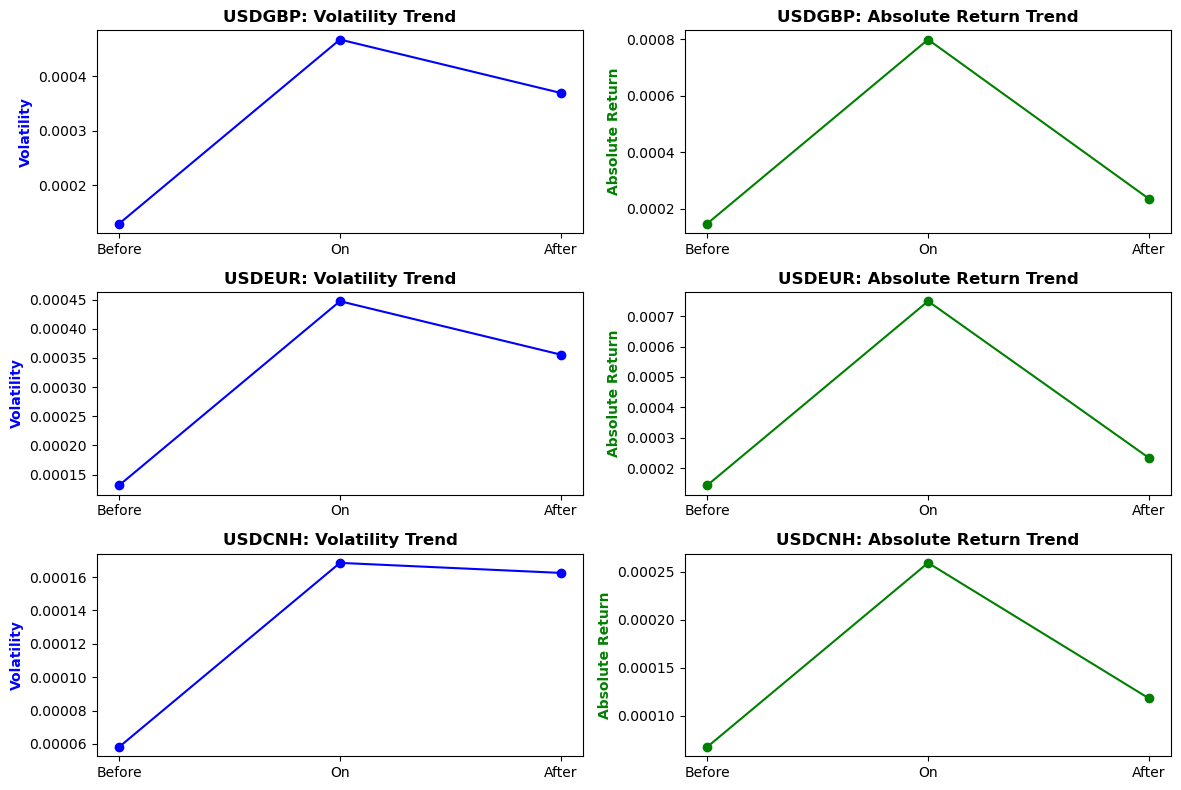

In [18]:
# Call the function for all three pairs
plot_fx_event_patterns(fx_analysis_results, ['USDGBP_AdjClose', 'USDEUR_AdjClose', 'USDCNH_AdjClose'])

### </span> <span style="color:blue">5.5 Summary Metrics of Market Reaction to Macro Events <a id="MacroVolatilitySummary"></a>
formatted summary table that captures key metrics of FX market reactions to different macroeconomic events. These metrics include the coefficient (`COEFF`), robustness (`ROB.T`), percentage jump in volatility (`%JUMP`), and percentage of daily volatility explained (`%DAY`). This summary helps quantify the impact of each macro event across different currency pairs.


In [19]:
# Create formatted summary
format_macro_summary_table(fx_analysis_results)

,PAIR,COUNTRY,EVENT,COEFF,ROB.T,%JUMP,%DAY
0,USDEUR,US,CPI,0.00055,4.71,370.68,100.14
1,USDEUR,US,GDP,0.00022,1.92,91.89,62.98
2,USDEUR,US,INTR,0.00085,3.57,256.92,112.70
3,USDEUR,US,PCE,0.00023,2.53,152.88,69.80
4,USDEUR,US,PMI,0.00018,1.63,63.40,57.58
5,USDEUR,US,UNRATE,0.00065,5.59,459.38,104.40
6,USDGBP,US,CPI,0.00061,4.70,369.77,103.97
7,USDGBP,US,GDP,0.00018,2.20,119.82,59.30
8,USDGBP,US,INTR,0.00089,3.73,273.40,107.15
9,USDGBP,US,PCE,0.00024,2.37,137.42,69.82


### <span style="color:blue">5.6 Macro Events Analyst Predictions vs Actual Outcomes </span> <a id="AnalystsExpectationsActuals"></a>
Bar chart indicating events that analysts have successfully predicted in the past and which ones are the ones that are harder to predict their values.

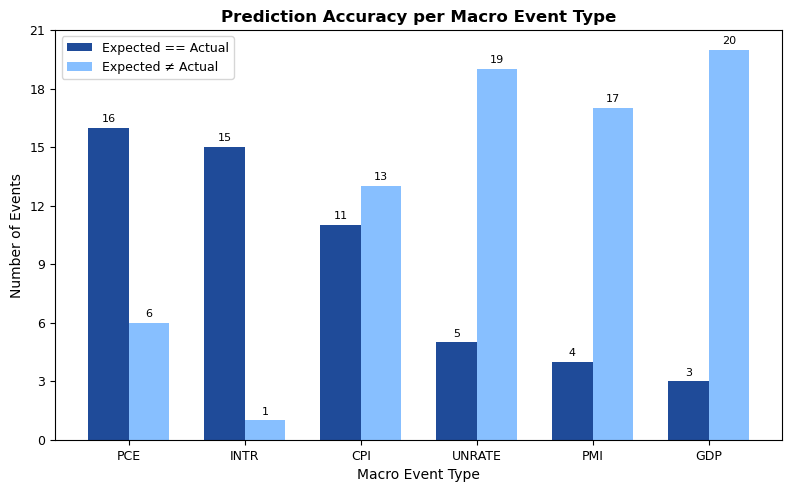

In [20]:
# Plot number of grouped events where analysts predicted the macro data accurately
plot_expectations_vs_actual(final_data)

### <span style="color:blue">5.7 Interdependence Between FX Pairs </span> <a id="PairsCorrelation"></a>
Correlation heatmap matrix of adjusted closing prices for different FX pairs. The heatmap quantifies the degree of interdependence between pairs adjusted close prices (e.g., USDEUR vs USDGBP).

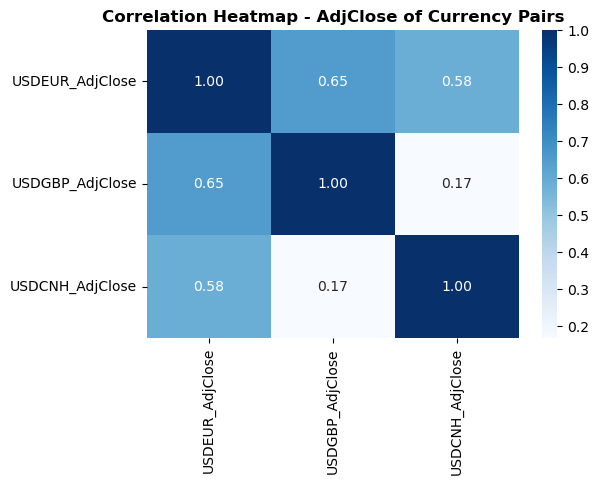

In [21]:
# Run the function
analyze_usd_pairs_correlation(final_data, macro_df)

---

---

# <span style="color:blue"> 6. Event Lower and Upper Bounds </span> <a id="EventBounds"></a>

This function estimates lower and upper bounds for the FX price at the exact minute a macro event occurs. It uses Monte Carlo simulations based on historical log returns from similar events, extracting the 5th and 95th percentiles to define the expected price range around the event.

In [22]:
def predict_mc_bounds(fx_pair: str, event_time: str, event_ticker: str, expected: float, actual: float, base_price: float):
    """
    Computes a widened Monte Carlo price bound for the first minute after a macro event.

    Params:
        fx_pair (str): Currency pair (e.g., 'USDEUR').
        event_time (str): Timestamp of the event (string format).
        event_ticker (str): Event identifier (e.g., 'CPI').
        expected (float): Expected value of the macro event.
        actual (float): Actual released value of the macro event.
        base_price (float): Last known FX price before the event.

    Returns:
        output_df (DataFrame): DataFrame with 11 bounds: Tuple of (lower_price, upper_price) for minute 0, else (None, None).
    """

    event_time = pd.to_datetime(event_time, dayfirst=True)
    surprise = actual - expected

    # Prepare data
    df_event = final_data[final_data['Ticker'] == event_ticker].copy()
    df_event['Datetime'] = df_event.index
    df_event['EventGroupID'] = (df_event['Datetime'].diff() > pd.Timedelta(minutes=1)).cumsum()

    # Extract event windows
    all_event_windows = []
    for _, group in df_event.groupby('EventGroupID'):
        group = group.reset_index(drop=True)
        if len(group) >= 16:
            try:
                window = group.loc[5:15].copy()
                window['MinuteOffset'] = range(0, len(window))
                window['Surprise'] = group['Surprise'].iloc[0]
                all_event_windows.append(window)
            except:
                continue

    if not all_event_windows:
        return pd.DataFrame(columns=["Datetime", "Bounds", "Ticker", "Expected", "Actual", "Surprise"])

    # Concatinate all event windows
    event_windows_df = pd.concat(all_event_windows)
    # Filter event windows that match the same event_ticker
    same_ticker = event_windows_df[event_windows_df['Ticker'] == event_ticker]
    # Use all minute-0 returns for this ticker
    returns = same_ticker[same_ticker['MinuteOffset'] == 0][f"{fx_pair}_log_return"].dropna()

    # Get base price if not provided
    if base_price is None:
        price_col = f"{fx_pair}_AdjClose"
        base_price = float(df_event[price_col].iloc[-1])

    simulated = np.random.choice(returns, size=100000, replace=True)
    lower, upper = np.percentile(simulated, [5, 95])

    # Convert to prices
    lower_price = round(base_price * np.exp(lower), 5)
    upper_price = round(base_price * np.exp(upper), 5)
    bounds = (lower_price, upper_price)

    # Build result (only minute 0 and rest as NaNs)
    result = []
    for i in range(11):  # 0 to +10 minutes
        dt = event_time + pd.Timedelta(minutes=i)
        result.append((dt, bounds if i == 0 else (None, None)))

    output_df = pd.DataFrame(result, columns=["Datetime", "Bounds"])
    output_df["Event"] = event_ticker
    output_df["Expected"] = expected
    output_df["Actual"] = actual
    output_df["Surprise"] = surprise

    return output_df

----------------------

-------

# <span style="color:blue">7. Prediction Algorithms </span> <a id="PredictionAlgorithms"></a>

### <span style="color:blue">7.1 GARCH(1,1) </span> <a id="GARCH(1,1)"></a>
A GARCH(1,1) model using pre-event log returns from historical macro events of the same type, then simulates FX returns over the next 11 minutes. It incorporates a surprise-adjusted boost at the event minute and averages multiple simulations to generate a stable post-event price path forecast. Predicted return and standard deviation are returned by this function.

In [23]:
def predict_garch_reaction_by_ticker(fx_pair: str, event_time: str, event_ticker: str,
                                     expected: float, actual: float, df: pd.DataFrame,
                                     window_minutes: int = 15, simulations: int = 20) -> pd.DataFrame:
    """
    Predict FX returns using GARCH(1,1) for a macro event, applying directional boost based on surprise.
    Uses multiple simulations and averages results for stability.

    Parameters:
        fx_pair (str): e.g., 'USDEUR'
        event_time (str): e.g., "10/03/2025 13:30"
        event_ticker (str): e.g., 'CPI'
        expected (float): Expected macro value
        actual (float): Actual macro value
        df (pd.DataFrame): FX and macro data with log returns
        window_minutes (int): Minutes before event used for fitting GARCH
        simulations (int): Number of GARCH simulations to average

    Returns:
        pd.DataFrame: Forecasted FX returns and prices for next 11 minutes
    """
    event_time = pd.to_datetime(event_time, dayfirst=True)
    log_return_col = f"{fx_pair}_log_return"
    surprise = actual - expected

    # Collect GARCH training data from N days of the same macro event
    df_ticker = df[df['Ticker'] == event_ticker].copy()
    df_ticker['Surprise'] = df_ticker['Actual'] - df_ticker['Expected']

    pre_event_returns = []
    minute_0_returns = []

    for ts in df_ticker.index.unique():
        day_start = ts.floor('D')
        event_idx = df.index.get_indexer([ts], method='nearest')[0]

        start_idx = event_idx - window_minutes
        end_idx = event_idx
        window_returns = df.iloc[start_idx:end_idx][log_return_col].dropna()

        if len(window_returns) == window_minutes:
            pre_event_returns.append(window_returns)

        try:
            r0 = df.iloc[event_idx][log_return_col]
            if not pd.isna(r0):
                minute_0_returns.append(r0)
        except:
            continue

    if len(pre_event_returns) < 5:
        raise ValueError("Not enough data for fitting GARCH")

    all_returns = pd.concat(pre_event_returns)
    model = arch_model(all_returns, vol='Garch', p=1, q=1)
    res = model.fit(disp="off")

    # Parameters
    omega = res.params['omega']
    alpha = res.params['alpha[1]']
    beta = res.params['beta[1]']
    mu = res.params['mu']
    avg_boost = np.mean(np.abs(minute_0_returns)) if minute_0_returns else 0

    # Run simulations and average
    return_matrix = np.zeros((simulations, 11))

    for sim in range(simulations):
        sigma2 = res.conditional_volatility[-1]**2
        last_resid = res.resid[-1]
        sim_returns = []

        for i in range(11):
            sigma2 = omega + alpha * last_resid**2 + beta * sigma2
            std = np.sqrt(sigma2)
            shock = np.random.normal(0, std)
            ret = mu + shock
            if i == 0:
                ret += np.sign(surprise) * avg_boost
            sim_returns.append(ret)
            last_resid = shock

        return_matrix[sim] = sim_returns

    mean_returns = return_matrix.mean(axis=0)
    std_returns = return_matrix.std(axis=0)

    # Convert to price path
    base_price_row = df[(df.index <= event_time) & (df['Ticker'] == event_ticker)]
    if base_price_row.empty:
        raise ValueError("Base price not found for event time")

    try:
        ts_before = event_time - timedelta(minutes=1)
        ts_base = final_data.loc[final_data.index < ts_before].index.max()
        base_price = final_data.loc[ts_base, f"{pair}_AdjClose"]
    except:
        raise ValueError("Base price not found for event time")
    #pred_prices = [base_price * np.prod(1 + mean_returns[:i + 1]) for i in range(11)]

    result_df = pd.DataFrame({
        'Datetime': [event_time + timedelta(minutes=i) for i in range(11)],
        'FX_Pair': fx_pair,
        'Predicted_Return': mean_returns,
        'Predicted_StdDev': std_returns,
        #'Predicted_Price': pred_prices,
        'Expected': expected,
        'Actual': actual,
        'Surprise': surprise,
        'Ticker': event_ticker
    })

    return result_df[['Datetime', 'FX_Pair', 'Predicted_Return', 'Predicted_StdDev',
                      'Expected', 'Actual', 'Surprise', 'Ticker']]
# # Run the function
predict_garch_reaction_by_ticker("USDGBP", "10/03/2025 13:30", "CPI", 0.4, 0.5, final_data)

C:\Users\modio\anaconda3\lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


,Datetime,FX_Pair,Predicted_Return,Predicted_StdDev,Expected,Actual,Surprise,Ticker
0,2025-03-10 13:30:00,USDGBP,0.001031,0.001425,0.4,0.5,0.1,CPI
1,2025-03-10 13:31:00,USDGBP,-0.000347,0.001247,0.4,0.5,0.1,CPI
2,2025-03-10 13:32:00,USDGBP,-0.000217,0.001828,0.4,0.5,0.1,CPI
3,2025-03-10 13:33:00,USDGBP,-0.000532,0.001910,0.4,0.5,0.1,CPI
4,2025-03-10 13:34:00,USDGBP,0.000004,0.001677,0.4,0.5,0.1,CPI
5,2025-03-10 13:35:00,USDGBP,-0.000437,0.001719,0.4,0.5,0.1,CPI
6,2025-03-10 13:36:00,USDGBP,-0.000873,0.001936,0.4,0.5,0.1,CPI
7,2025-03-10 13:37:00,USDGBP,-0.000089,0.001313,0.4,0.5,0.1,CPI
8,2025-03-10 13:38:00,USDGBP,0.000265,0.001950,0.4,0.5,0.1,CPI
9,2025-03-10 13:39:00,USDGBP,-0.000166,0.001819,0.4,0.5,0.1,CPI


### <span style="color:blue">7.2 LSTM </span> <a id="LSTM"></a>

#### <span style="color:blue">7.2.1 LSTM Implementation </span> <a id="LSTMImplementation"></a>
This LSTM model is trained per FX pair using sequences of length 5 (5 past known values) to forecast the next 11 minutes on and after macro events. It's training uses event-weighted, runs for 200 epochs with a batch size of 32, normilizes the data and create event sequences for a better learning process.

In [24]:
def train_lstm_for_pair(final_data, pair_fx, sequence_length=5, forecast_horizon=11, epochs=200, batch_size=32):
    """
    Trains an LSTM model to forecast FX prices for macro events, with custom attenuation for low-movement event types.

    Params:
        final_data (DataFrame): Full historical FX and event dataset.
        pair_fx (str): Currency pair prefix (e.g., 'USDEUR').
        sequence_length (int): Number of past steps used as input.
        forecast_horizon (int): Number of future steps to predict.
        epochs (int): Training epochs.
        batch_size (int): Batch size for training.

    Returns:
        model: Trained Keras LSTM model.
        demo_preds (list): Predicted sequences for demo events.
        demo_actuals (list): Actual sequences for demo events.
        demo_inputs (list): Input sequences used for demo prediction.
        price_scaler (MinMaxScaler): Scaler for inverse-transforming prices.
        scaler (MinMaxScaler): Scaler for full input features.
        features (list): List of feature names used in training.
        pair_fx (str): Currency pair name.
        df (DataFrame): Preprocessed DataFrame with features.
        demo_events (list): List of demo event types used.
    """
    df = final_data.copy().reset_index()
    df['Datetime'] = pd.to_datetime(df['Datetime'])

    # 1. Select features
    features = [
        f'{pair_fx}_AdjClose',
        f'{pair_fx}_Volume',
        f'{pair_fx}_vwap',
        f'{pair_fx}_Volatility',
        f'{pair_fx}_AverageVolatility',
        'Ticker', 'Expected', 'Actual', 'Surprise'
    ]
    df = df[['Datetime'] + features]

    # 2. Encode Ticker
    df['Ticker'] = df['Ticker'].astype('category')
    ticker_categories = df['Ticker'].cat.categories
    df['Ticker'] = df['Ticker'].cat.codes
    event_to_code = dict(zip(ticker_categories, range(len(ticker_categories))))

    # 3. Scale
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[features])
    scaled_df = pd.DataFrame(scaled_data, columns=features)
    scaled_df['Ticker'] = df['Ticker'].values

    price_scaler = MinMaxScaler()
    price_scaler.fit(df[[f'{pair_fx}_AdjClose']])

    # 4. Create sequences aligned to events
    def get_event_windows(total_rows, event_size=16, start_pred_idx=5, horizon=11):
        windows = []
        for event_start in range(0, total_rows, event_size):
            input_start = event_start + start_pred_idx - sequence_length
            pred_start = event_start + start_pred_idx
            pred_end = pred_start + horizon
            if input_start >= event_start and pred_end <= event_start + event_size:
                windows.append((input_start, pred_start, pred_end))
        return windows

    X, y, meta_indices = [], [], []
    windows = get_event_windows(len(scaled_df), event_size=16, start_pred_idx=5, horizon=forecast_horizon)
    for input_start, pred_start, pred_end in windows:
        seq_x = scaled_df.iloc[input_start:input_start + sequence_length][features].values
        base_price = scaled_df.iloc[input_start + sequence_length - 1][f'{pair_fx}_AdjClose']
        future_y = scaled_df.iloc[pred_start:pred_end][f'{pair_fx}_AdjClose'].values
        y_full = np.concatenate([[base_price], future_y])  # [known base] + [11 steps]
        X.append(seq_x)
        y.append(y_full)
        meta_indices.append(input_start + sequence_length)

    X, y = np.array(X), np.array(y)

    # 5. Train/test split
    val_size = max(6, int(0.1 * len(X)))
    demo_size = max(6, int(0.2 * len(X)))

    X_train, y_train = X[:-val_size - demo_size], y[:-val_size - demo_size]
    X_val, y_val = X[-val_size - demo_size:-demo_size], y[-val_size - demo_size:-demo_size]
    X_demo, y_demo = X[-demo_size:], y[-demo_size:]
    demo_indices = meta_indices[-demo_size:]

    # 6. Build and train model
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=(sequence_length, X.shape[2])),
        LSTM(64),
        Dense(forecast_horizon)
        ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(
            X_train, y_train[:, 1:],  
            validation_data=(X_val, y_val[:, 1:]),
            epochs=epochs,
            batch_size=batch_size
        )

    # 7. Predict on demo events
    demo_inputs, demo_preds, demo_actuals, demo_events, demo_event_info = [], [], [], [], []
    low_movement_events = {'PMI', 'PCE', 'GDP'}
    attenuation_factor_non_chinese = 0.15
    attenuation_factor_chinese = 0.15

    for i in range(len(X_demo)):
        sample_input = X_demo[i].reshape(1, sequence_length, X.shape[2])
        pred_steps = model.predict(sample_input, verbose=0)[0]
        base_price = X_demo[i][-1, 0]
        sample_pred = np.concatenate([[base_price], pred_steps])  # 12 values (last known + on event (pred) + 10 after (pred))
        sample_actual = y_demo[i]  

        row_idx = demo_indices[i]
        raw_row = df.iloc[row_idx]
        event_name = ticker_categories[int(raw_row['Ticker'])]

        # Apply attenuation
        if event_name in low_movement_events:
            factor = attenuation_factor_chinese if 'CNY' in pair_fx.upper() or 'CNH' in pair_fx.upper() else attenuation_factor_non_chinese
            sample_pred = base_price + factor * (sample_pred - base_price)

        if event_name in {'INTR', 'UNRATE'}:
            sample_pred[-1] = base_price + 0.1 * (sample_pred[-1] - base_price)

        # Inverse transform
        pred_real = price_scaler.inverse_transform(sample_pred.reshape(-1, 1)).flatten()
        actual_real = price_scaler.inverse_transform(sample_actual.reshape(-1, 1)).flatten()

        demo_inputs.append(sample_input)
        demo_preds.append(sample_pred)
        demo_actuals.append(sample_actual)
        demo_events.append(event_name)
        demo_event_info.append({
            "pair": pair_fx,
            "ticker": event_name,
            "start_datetime": raw_row['Datetime'],
            "expected": raw_row['Expected'],
            "actual": raw_row['Actual'],
            "true_prices": actual_real.tolist(),
            "pred_prices": pred_real.tolist()
        })

    return model, demo_preds, demo_actuals, demo_inputs, price_scaler, scaler, features, pair_fx, df, demo_events, demo_event_info

#### <span style="color:blue">7.2.2 LSTM training & validation for all pairs across all events </span> <a id="LSTMTrainValidation"></a>
Performs separate training and validation loops for each currency pair. Both training and validation sets are constructed to include more than one occurrence of all 6 distinct event types for each FX pair.

In [25]:
pair_fx_list = ['USDEUR', 'USDGBP', 'USDCNH']
results = {}

for pair_fx in pair_fx_list:
    model, preds, actuals, inputs, price_scaler, scaler, features, fx_name, df, events, demo_event_info = train_lstm_for_pair(final_data, pair_fx)

    # Check for missing events on validation sets
    expected_events = {'CPI', 'GDP', 'INTR', 'PCE', 'PMI', 'UNRATE'}
    missing = expected_events - set(events)
    if missing:
        print(f"[******WARNING******] {pair_fx} is missing events: {', '.join(missing)}\n")
    else:
        print(f"[OK] {pair_fx} contains all 6 macro events.\n")

    results[pair_fx] = {
        'model': model,
        'preds': np.round(preds,4),
        'actuals': np.round(actuals,4),
        'inputs': inputs,
        'price_scaler': price_scaler,
        'scaler': scaler,
        'features': features,
        'fx_name': fx_name,
        'df': df,
        'events': events,
        'demo_event_info': demo_event_info  
    }

Epoch 1/200
3/3 [==============================] - 5s 462ms/step - loss: 0.1368 - val_loss: 0.0285
Epoch 2/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0742 - val_loss: 0.0260
Epoch 3/200
3/3 [==============================] - 0s 31ms/step - loss: 0.0445 - val_loss: 0.0414
Epoch 4/200
3/3 [==============================] - 0s 27ms/step - loss: 0.0384 - val_loss: 0.0501
Epoch 5/200
3/3 [==============================] - 0s 29ms/step - loss: 0.0351 - val_loss: 0.0410
Epoch 6/200
3/3 [==============================] - 0s 25ms/step - loss: 0.0289 - val_loss: 0.0313
Epoch 7/200
3/3 [==============================] - 0s 24ms/step - loss: 0.0228 - val_loss: 0.0275
Epoch 8/200
3/3 [==============================] - 0s 26ms/step - loss: 0.0195 - val_loss: 0.0258
Epoch 9/200
3/3 [==============================] - 0s 24ms/step - loss: 0.0179 - val_loss: 0.0249
Epoch 10/200
3/3 [==============================] - 0s 24ms/step - loss: 0.0167 - val_loss: 0.0243
Epoch 11/200
3/3 [

Epoch 80/200
3/3 [==============================] - 0s 25ms/step - loss: 2.7588e-04 - val_loss: 3.8861e-04
Epoch 81/200
3/3 [==============================] - 0s 25ms/step - loss: 3.0082e-04 - val_loss: 2.4447e-04
Epoch 82/200
3/3 [==============================] - 0s 25ms/step - loss: 2.9819e-04 - val_loss: 4.2445e-04
Epoch 83/200
3/3 [==============================] - 0s 27ms/step - loss: 3.1950e-04 - val_loss: 2.3749e-04
Epoch 84/200
3/3 [==============================] - 0s 25ms/step - loss: 3.4185e-04 - val_loss: 2.9349e-04
Epoch 85/200
3/3 [==============================] - 0s 28ms/step - loss: 2.8023e-04 - val_loss: 2.7274e-04
Epoch 86/200
3/3 [==============================] - 0s 27ms/step - loss: 2.9920e-04 - val_loss: 2.4465e-04
Epoch 87/200
3/3 [==============================] - 0s 27ms/step - loss: 3.1187e-04 - val_loss: 3.6361e-04
Epoch 88/200
3/3 [==============================] - 0s 30ms/step - loss: 2.8982e-04 - val_loss: 2.2070e-04
Epoch 89/200
3/3 [===================

3/3 [==============================] - 0s 25ms/step - loss: 2.7177e-04 - val_loss: 1.6073e-04
Epoch 157/200
3/3 [==============================] - 0s 25ms/step - loss: 2.6738e-04 - val_loss: 1.9055e-04
Epoch 158/200
3/3 [==============================] - 0s 23ms/step - loss: 2.5946e-04 - val_loss: 1.8013e-04
Epoch 159/200
3/3 [==============================] - 0s 23ms/step - loss: 2.5659e-04 - val_loss: 1.5583e-04
Epoch 160/200
3/3 [==============================] - 0s 26ms/step - loss: 2.5929e-04 - val_loss: 1.7163e-04
Epoch 161/200
3/3 [==============================] - 0s 27ms/step - loss: 2.5026e-04 - val_loss: 1.6577e-04
Epoch 162/200
3/3 [==============================] - 0s 25ms/step - loss: 2.6252e-04 - val_loss: 1.5199e-04
Epoch 163/200
3/3 [==============================] - 0s 25ms/step - loss: 2.6151e-04 - val_loss: 2.1025e-04
Epoch 164/200
3/3 [==============================] - 0s 25ms/step - loss: 2.7458e-04 - val_loss: 1.5769e-04
Epoch 165/200
3/3 [=======================

3/3 [==============================] - 0s 26ms/step - loss: 0.0011 - val_loss: 0.0043
Epoch 35/200
3/3 [==============================] - 0s 24ms/step - loss: 9.5233e-04 - val_loss: 0.0036
Epoch 36/200
3/3 [==============================] - 0s 25ms/step - loss: 8.3029e-04 - val_loss: 0.0031
Epoch 37/200
3/3 [==============================] - 0s 24ms/step - loss: 7.5867e-04 - val_loss: 0.0029
Epoch 38/200
3/3 [==============================] - 0s 25ms/step - loss: 6.9087e-04 - val_loss: 0.0028
Epoch 39/200
3/3 [==============================] - 0s 28ms/step - loss: 5.9098e-04 - val_loss: 0.0029
Epoch 40/200
3/3 [==============================] - 0s 26ms/step - loss: 5.0940e-04 - val_loss: 0.0025
Epoch 41/200
3/3 [==============================] - 0s 25ms/step - loss: 4.9158e-04 - val_loss: 0.0027
Epoch 42/200
3/3 [==============================] - 0s 25ms/step - loss: 4.0201e-04 - val_loss: 0.0025
Epoch 43/200
3/3 [==============================] - 0s 24ms/step - loss: 3.9401e-04 - val_

3/3 [==============================] - 0s 26ms/step - loss: 2.4443e-04 - val_loss: 0.0011
Epoch 114/200
3/3 [==============================] - 0s 29ms/step - loss: 2.0933e-04 - val_loss: 0.0015
Epoch 115/200
3/3 [==============================] - 0s 25ms/step - loss: 2.8163e-04 - val_loss: 9.4521e-04
Epoch 116/200
3/3 [==============================] - 0s 24ms/step - loss: 2.8137e-04 - val_loss: 0.0014
Epoch 117/200
3/3 [==============================] - 0s 24ms/step - loss: 2.0419e-04 - val_loss: 9.9734e-04
Epoch 118/200
3/3 [==============================] - 0s 24ms/step - loss: 2.6192e-04 - val_loss: 0.0014
Epoch 119/200
3/3 [==============================] - 0s 25ms/step - loss: 2.4344e-04 - val_loss: 0.0011
Epoch 120/200
3/3 [==============================] - 0s 24ms/step - loss: 1.9913e-04 - val_loss: 0.0013
Epoch 121/200
3/3 [==============================] - 0s 25ms/step - loss: 2.1354e-04 - val_loss: 9.8832e-04
Epoch 122/200
3/3 [==============================] - 0s 24ms/step 

3/3 [==============================] - 0s 30ms/step - loss: 2.1325e-04 - val_loss: 9.4125e-04
Epoch 192/200
3/3 [==============================] - 0s 31ms/step - loss: 2.0049e-04 - val_loss: 9.8230e-04
Epoch 193/200
3/3 [==============================] - 0s 30ms/step - loss: 1.8906e-04 - val_loss: 9.8349e-04
Epoch 194/200
3/3 [==============================] - 0s 29ms/step - loss: 1.9502e-04 - val_loss: 0.0010
Epoch 195/200
3/3 [==============================] - 0s 27ms/step - loss: 1.8952e-04 - val_loss: 0.0010
Epoch 196/200
3/3 [==============================] - 0s 28ms/step - loss: 1.9610e-04 - val_loss: 0.0011
Epoch 197/200
3/3 [==============================] - 0s 29ms/step - loss: 1.9344e-04 - val_loss: 8.7239e-04
Epoch 198/200
3/3 [==============================] - 0s 30ms/step - loss: 2.0627e-04 - val_loss: 9.2033e-04
Epoch 199/200
3/3 [==============================] - 0s 25ms/step - loss: 1.8655e-04 - val_loss: 9.0382e-04
Epoch 200/200
3/3 [==============================] - 0

3/3 [==============================] - 0s 24ms/step - loss: 1.6275e-04 - val_loss: 4.2156e-04
Epoch 70/200
3/3 [==============================] - 0s 25ms/step - loss: 1.6411e-04 - val_loss: 3.1982e-04
Epoch 71/200
3/3 [==============================] - 0s 23ms/step - loss: 1.5371e-04 - val_loss: 3.7322e-04
Epoch 72/200
3/3 [==============================] - 0s 24ms/step - loss: 1.5189e-04 - val_loss: 3.3910e-04
Epoch 73/200
3/3 [==============================] - 0s 25ms/step - loss: 1.5549e-04 - val_loss: 3.3719e-04
Epoch 74/200
3/3 [==============================] - 0s 24ms/step - loss: 1.5225e-04 - val_loss: 3.2774e-04
Epoch 75/200
3/3 [==============================] - 0s 24ms/step - loss: 1.4361e-04 - val_loss: 3.5010e-04
Epoch 76/200
3/3 [==============================] - 0s 24ms/step - loss: 1.4624e-04 - val_loss: 3.1281e-04
Epoch 77/200
3/3 [==============================] - 0s 25ms/step - loss: 1.5796e-04 - val_loss: 3.6376e-04
Epoch 78/200
3/3 [==============================] 

3/3 [==============================] - 0s 24ms/step - loss: 1.1417e-04 - val_loss: 2.2238e-04
Epoch 146/200
3/3 [==============================] - 0s 25ms/step - loss: 1.1410e-04 - val_loss: 2.1975e-04
Epoch 147/200
3/3 [==============================] - 0s 25ms/step - loss: 1.1484e-04 - val_loss: 2.5325e-04
Epoch 148/200
3/3 [==============================] - 0s 25ms/step - loss: 1.0726e-04 - val_loss: 2.2862e-04
Epoch 149/200
3/3 [==============================] - 0s 26ms/step - loss: 1.0928e-04 - val_loss: 2.4300e-04
Epoch 150/200
3/3 [==============================] - 0s 24ms/step - loss: 1.1850e-04 - val_loss: 2.0711e-04
Epoch 151/200
3/3 [==============================] - 0s 24ms/step - loss: 1.1640e-04 - val_loss: 2.5435e-04
Epoch 152/200
3/3 [==============================] - 0s 26ms/step - loss: 1.1465e-04 - val_loss: 1.9755e-04
Epoch 153/200
3/3 [==============================] - 0s 24ms/step - loss: 1.0490e-04 - val_loss: 2.5220e-04
Epoch 154/200
3/3 [=======================

#### <span style="color:blue">7.2.3 LSTM Plotting Actual vs Predictions </span> <a id="LSTMActualVSPredictions"></a>
This chart visualizes the LSTM model's forecasts against actual FX price movements for 6 distinct macroeconomic events across 3 USD pairs. Each subplot highlights how the model performs around event time (T-1 to T+10), enabling a side-by-side comparison of predicted versus realized market reactions. Where the prediction (event) data is announced, a dotted vertical line has been drawn.

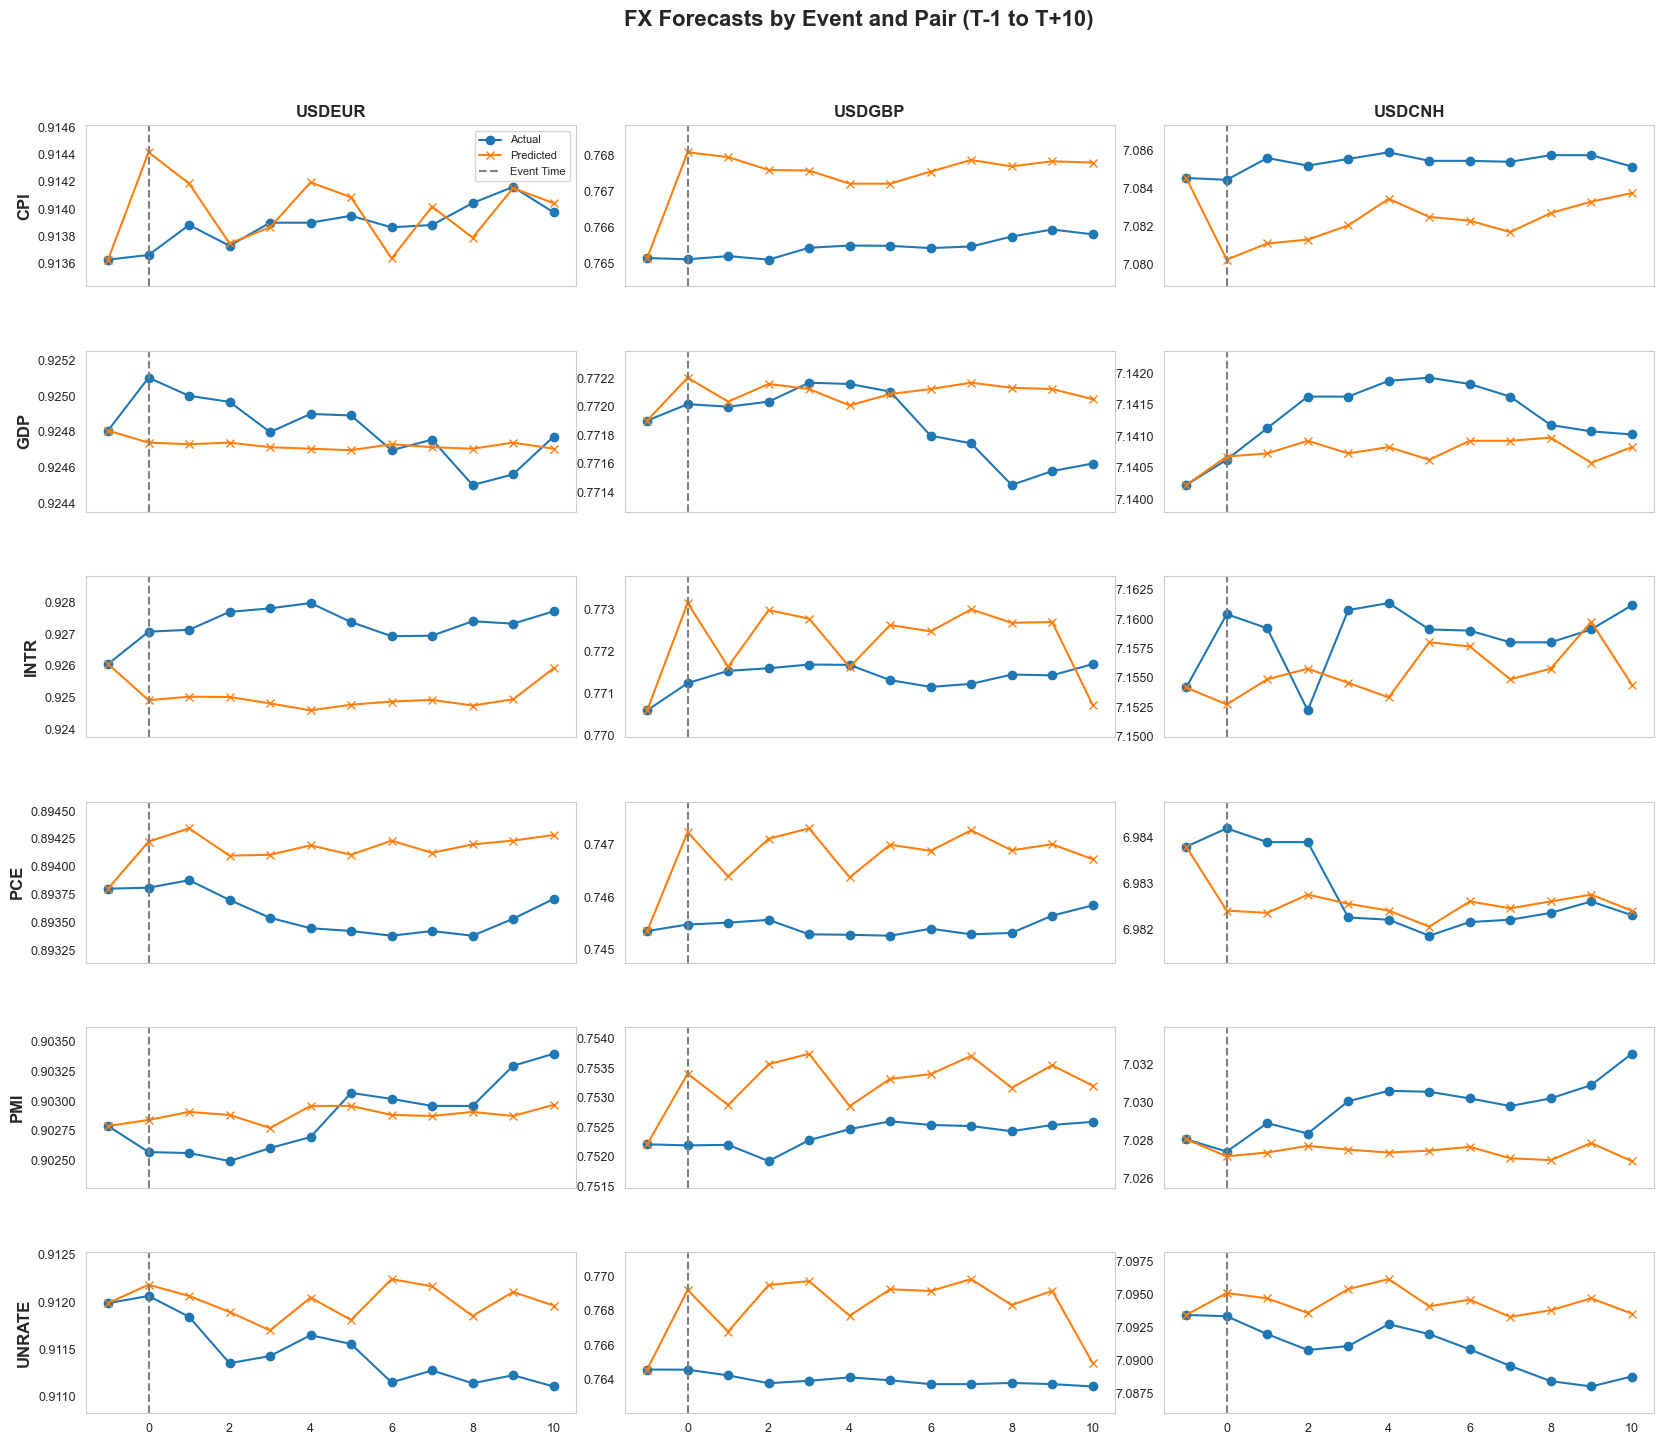

In [26]:
plot_one_of_each_event_all_pairs(results)

---

-----

# <span style="color:blue">8. Evaluation Algorithms </span> <a id="EvaluationAlgorithms"></a>

### <span style="color:blue">8.1 MC Bounds Evaluation </span> <a id="MCBounds"></a>
FX prices are extracted and Monte Carlo bounds are computed. Then, a check occurs to review whether actual prices fall within, above, or below the predicted bounds. This is applied across all macro events and FX pairs.

In [26]:
def check_mc_bounds_on_all_events(final_data):
    """
    Processes FX event data to extract open prices, compute Monte Carlo prediction bounds,
    and evaluate whether actual prices fall within, above, or below those bounds.

    Parameters:
        final_data (pd.DataFrame): A DataFrame with Datetime index and columns including
                                   *_AdjClose, Ticker, Expected, and Actual.

    Returns:
        Tuple:
            - pd.DataFrame: Event rows with *_open_price and *_bounds columns added.
            - pd.DataFrame: Summary table of bound evaluation for each FX pair.
    """
    
    # Step 1: Prepare base data
    df = final_data.reset_index()[[
        "Datetime", "USDEUR_AdjClose", "USDGBP_AdjClose", "USDCNH_AdjClose", "Ticker", "Expected", "Actual"
    ]].copy()

    df['Datetime'] = final_data.index
    df['Date'] = df['Datetime'].dt.date
    df = df.sort_values('Datetime')

    # Step 2: Get 5th (open price) and 6th (event reaction) rows per (Date, Ticker)
    open_rows = df.groupby(['Date', 'Ticker'], group_keys=False).apply(lambda x: x.iloc[4:5]).reset_index(drop=True)
    event_rows = df.groupby(['Date', 'Ticker'], group_keys=False).apply(lambda x: x.iloc[5:6]).reset_index(drop=True)

    # Step 3: Copy open prices into event rows
    for col in ["USDEUR", "USDGBP", "USDCNH"]:
        event_rows[f"{col}_open_price"] = open_rows[f"{col}_AdjClose"].values

    # Step 4: Predict bounds
    def get_bounds(row, fx):
        try:
            df_bounds = predict_mc_bounds(
                fx_pair=fx,
                event_time=row['Datetime'],
                event_ticker=row['Ticker'],
                expected=row['Expected'],
                actual=row['Actual'],
                base_price=row[f"{fx}_open_price"]
            )
            return df_bounds.iloc[0]['Bounds']
        except:
            return (None, None)

    for fx in ["USDEUR", "USDGBP", "USDCNH"]:
        event_rows[f"{fx}_bounds"] = event_rows.apply(lambda row: get_bounds(row, fx), axis=1)

    # Step 5: Evaluate results
    summary = {}
    for fx in ["USDEUR", "USDGBP", "USDCNH"]:
        actual = event_rows[f"{fx}_AdjClose"]
        bounds = event_rows[f"{fx}_bounds"]
        within = above = below = 0

        for price, bound in zip(actual, bounds):
            if bound is None or bound[0] is None:
                continue
            low, high = bound
            if low <= price <= high:
                within += 1
            elif price > high:
                above += 1
            elif price < low:
                below += 1

        summary[fx] = {
            "Within_Bounds": within,
            "Above_Bounds": above,
            "Below_Bounds": below,
            "Total_Evaluated": within + above + below
        }
    
    summary = pd.DataFrame(summary).T
    
    summary["Within bounds %"] = round(summary["Within_Bounds"] / summary["Total_Evaluated"], 2) 
    
    event_rows = event_rows[["Datetime", "Ticker", "Expected", "Actual", 
                             "USDEUR_AdjClose", "USDGBP_AdjClose", "USDCNH_AdjClose", 
                            "USDEUR_bounds", "USDGBP_bounds", "USDCNH_bounds"]]
    
    return event_rows, summary

### <span style="color:blue">8.2 Compute KPIs </span> <a id="ComputeKPIs"></a>
Evaluation metrics MAE, RMSE, MAPE, R², and Directional Accuracy are being calculated. 
The metrics are computed for the first step (t+1) and averaged over all 11 steps. This is to assess the forecasting on the macro event data release separately however of the whole sequence of the 11 steps from the event until the next 10 minutes too.

In [27]:
def compute_kpis(true_prices, pred_prices, base_prices):
    """
    Computes MAE, RMSE, MAPE, R2, and DA at t+1 and averaged over forecast horizon.

    Parameters:
        true_prices: np.array shape (n_events, n_steps)
        pred_prices: np.array shape (n_events, n_steps)
        base_prices: np.array shape (n_events,)

    Returns:
        dict of KPIs
    """

    # Ensure inputs are arrays
    y_true = np.array(true_prices)
    y_pred = np.array(pred_prices)
    last_known = np.array(base_prices)

    # KPIs at t+1 (first prediction step)
    y_a1 = y_true[:, 0]
    y_p1 = y_pred[:, 0]
    mae_1 = mean_absolute_error(y_a1, y_p1)
    rmse_1 = mean_squared_error(y_a1, y_p1, squared=False)
    mape_1 = np.mean(np.abs((y_a1 - y_p1) / y_a1)) * 100
    r2_1 = r2_score(y_a1, y_p1)

    actual_dir = np.sign(y_a1 - last_known)
    predicted_dir = np.sign(y_p1 - last_known)
    da_1 = np.mean(actual_dir == predicted_dir)

    # KPIs over full horizon
    mae_all = mean_absolute_error(y_true.flatten(), y_pred.flatten())
    rmse_all = mean_squared_error(y_true.flatten(), y_pred.flatten(), squared=False)
    mape_all = np.mean(np.abs((y_true.flatten() - y_pred.flatten()) / y_true.flatten())) * 100
    r2_all = r2_score(y_true.flatten(), y_pred.flatten())

    da_all = np.mean([
        np.mean(np.sign(y_true[i] - last_known[i]) == np.sign(y_pred[i] - last_known[i]))
        for i in range(len(y_true))
    ])

    return {
        'pair': pair,
        'MAE_t+1': round(mae_1, 4),
        'RMSE_t+1': round(rmse_1, 4),
        'MAPE_t+1': round(mape_1, 4),
        'R2_t+1': round(r2_1, 2),
        'DA_t+1': round(da_1, 2),
        'MAE_avg': round(mae_all, 4),
        'RMSE_avg': round(rmse_all, 4),
        'MAPE_avg': round(mape_all, 4),
        'R2_avg': round(r2_all, 2),
        'DA_avg': round(da_all, 2)
        }

### <span style="color:blue">8.3 GARCH(1,1) KPIs Evaluation </span> <a id="GARCHEvaluation"></a>
GARCH(1,1) KPIs are computed on the same validation samples used during LSTM training/validation. This ensures consistent evaluation across models using identical data splits and metrics.

In [28]:
def evaluate_garch_kpis(results_dict):
    """
    Runs GARCH and computes KPIs consistently with LSTM metrics.

    Returns:
        pd.DataFrame: One row per FX pair with averaged KPIs.
    """
    garch_kpis = []

    for pair in results_dict:
        true_list, pred_list, base_list = [], [], []

        for event in results_dict[pair]['demo_event_info']:
            try:
                ticker = event['ticker']
                start = event['start_datetime']
                expected = event['expected']
                actual_val = event['actual']
                true_prices = np.array(event['true_prices'])
                base_price = true_prices[0]
                true_future = true_prices[1:]

                garch_df = predict_garch_reaction_by_ticker(pair, str(start), ticker, expected, actual_val, final_data)

                pred_returns = garch_df['Predicted_Return'].values # percentage returns 
                cumulative_returns = np.cumprod(1 + pred_returns[:len(true_future)]) # cumulative percentage retuns
                pred_prices = base_price * cumulative_returns # percentage returns to close prices

                true_list.append(true_future)
                pred_list.append(pred_prices)
                base_list.append(base_price)

            except Exception:
                continue

        if true_list:
            kpis = compute_kpis(true_list, pred_list, base_list)
            kpis['pair'] = pair
            garch_kpis.append(kpis)

    return pd.DataFrame(garch_kpis)

### <span style="color:blue">8.4 LSTM KPIs Evaluation </span> <a id="LSTMEvaluation"></a>
LSTM KPI metrics evaluation based on the prediction sample that was created during the LSTM implementation.

In [29]:
def evaluate_lstm_kpis(results_dict):
    """
    Computes KPIs for LSTM predictions for each FX pair using compute_kpis().

    Returns:
        pd.DataFrame: One row per FX pair with averaged KPIs.
    """
    lstm_kpis = []

    for pair in results_dict:
        true_list, pred_list, base_list = [], [], []

        for event in results_dict[pair]['demo_event_info']:
            try:
                true = np.array(event['true_prices'][1:])
                pred = np.array(event['pred_prices'][1:])
                base = event['true_prices'][0]

                if len(true) != len(pred):
                    continue

                true_list.append(true)
                pred_list.append(pred)
                base_list.append(base)

            except Exception:
                continue

        if true_list:
            kpis = compute_kpis(true_list, pred_list, base_list)
            kpis['pair'] = pair
            lstm_kpis.append(kpis)

    return pd.DataFrame(lstm_kpis)

--------

----

# <span style="color:blue"> 9. KPI Metrics Results </span> <a id="KPIsResults"></a>

### <span style="color:blue">9.1 Bounds test results </span> <a id="MCBoundsResults"></a>

In [30]:
# Call the function
df_with_bounds, bounds_stats = check_mc_bounds_on_all_events(final_data)

# Display the dataframe with the 130 events (only their event minute) along with the bounds and events info
print("All Events Bounds")
display(df_with_bounds)

# Display information about events within and outside the bounds 
print("\n\nBounds Results")
display(bounds_stats)

All Events Bounds


,Datetime,Ticker,Expected,Actual,USDEUR_AdjClose,USDGBP_AdjClose,USDCNH_AdjClose,USDEUR_bounds,USDGBP_bounds,USDCNH_bounds
0,2023-03-10 13:30:00,UNRATE,3.4,3.6,0.94120,0.83101,6.95208,"(0.9412, 0.9486)","(0.83101, 0.83713)","(6.95017, 6.96622)"
1,2023-03-14 12:30:00,CPI,0.4,0.4,0.93092,0.82010,6.86558,"(0.92911, 0.9357)","(0.81752, 0.82443)","(6.86558, 6.87911)"
2,2023-03-22 18:00:00,INTR,5.0,5.0,0.92297,0.81367,6.86955,"(0.92284, 0.92909)","(0.81262, 0.81949)","(6.86211, 6.87709)"
3,2023-03-30 13:30:00,GDP,2.7,2.6,0.91608,0.80800,6.88211,"(0.91563, 0.91648)","(0.80768, 0.80842)","(6.8792, 6.88318)"
4,2023-03-31 13:30:00,PCE,0.3,0.3,0.91917,0.80799,6.86970,"(0.91822, 0.91986)","(0.80742, 0.80879)","(6.86852, 6.8737)"
...,...,...,...,...,...,...,...,...,...,...
125,2025-01-29 19:00:00,INTR,4.5,4.5,0.96137,0.80433,7.26893,"(0.956, 0.96247)","(0.79975, 0.80652)","(7.25317, 7.269)"
126,2025-01-30 13:30:00,GDP,2.6,2.3,0.96073,0.80398,7.26677,"(0.95908, 0.95997)","(0.80312, 0.80386)","(7.26257, 7.26677)"
127,2025-01-31 13:30:00,PCE,0.3,0.3,0.96316,0.80535,7.29443,"(0.96135, 0.96306)","(0.80457, 0.80592)","(7.29195, 7.29746)"
128,2025-02-07 13:30:00,UNRATE,4.1,4.1,0.96484,0.80369,7.29015,"(0.96085, 0.96841)","(0.8005, 0.8064)","(7.28708, 7.30392)"




Bounds Results


,Within_Bounds,Above_Bounds,Below_Bounds,Total_Evaluated,Within bounds %
USDEUR,120,5,5,130,0.92
USDGBP,120,5,5,130,0.92
USDCNH,120,5,5,130,0.92


### <span style="color:blue">9.2 GARCH & LSTM Evaluation Results </span> <a id="GARCHandLSTMKPIS"></a>

In [31]:
garch_kpis = evaluate_garch_kpis(results)
display(garch_kpis)
print("GARCH(1,1) KPIs Evaluation Results above")

lstm_kpis = evaluate_lstm_kpis(results)
display(lstm_kpis)
print("LSTM KPIs Evaluation Results above")

C:\Users\modio\anaconda3\lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\modio\anaconda3\lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\modio\anaconda3\lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\modio\anaconda3\lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\modio\anaconda3\lib\site-pa

C:\Users\modio\anaconda3\lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\modio\anaconda3\lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\modio\anaconda3\lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\modio\anaconda3\lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\modio\anaconda3\lib\site-pa

C:\Users\modio\anaconda3\lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\modio\anaconda3\lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\modio\anaconda3\lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\modio\anaconda3\lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\modio\anaconda3\lib\site-pa

,pair,MAE_t+1,RMSE_t+1,MAPE_t+1,R2_t+1,DA_t+1,MAE_avg,RMSE_avg,MAPE_avg,R2_avg,DA_avg
0,USDEUR,0.0012,0.0019,0.1283,0.99,0.42,0.0018,0.0028,0.1865,0.98,0.62
1,USDGBP,0.0012,0.0019,0.1441,0.99,0.38,0.0015,0.0022,0.1843,0.99,0.42
2,USDCNH,0.0036,0.0053,0.0503,1.00,0.46,0.0048,0.0066,0.0657,1.00,0.66


GARCH(1,1) KPIs Evaluation Results above


,pair,MAE_t+1,RMSE_t+1,MAPE_t+1,R2_t+1,DA_t+1,MAE_avg,RMSE_avg,MAPE_avg,R2_avg,DA_avg
0,USDEUR,0.0025,0.0041,0.2628,0.97,0.35,0.0025,0.0042,0.2630,0.97,0.40
1,USDGBP,0.0013,0.0020,0.1645,0.99,0.62,0.0015,0.0023,0.1900,0.99,0.59
2,USDCNH,0.0042,0.0072,0.0582,0.99,0.46,0.0051,0.0077,0.0695,0.99,0.46


LSTM KPIs Evaluation Results above


---

---

# <span style="color:blue">10. Single Event Predictions </span> <a id="SingleEventPredictions"></a>

### <span style="color:blue">10.1 LSTM Price Prediction</span> <a id="LSTMSingleEvent"></a>
This function enables the use of the trained and validated LSTM model to generate predictions for new or individual macro events. Given the latest sequence of features, it forecasts the FX price at the event time and for the following 10 minutes.

In [32]:
def forecast_lstm_event_fx(pair_fx, start_datetime_str, raw_input, results_dict):
    """
    Predicts FX prices and returns a DataFrame with forecast horizon.

    Args:
        pair_fx (str): e.g., 'USDEUR'
        start_datetime_str (str): e.g., '10/03/2025 13:30'
        raw_input (np.ndarray): shape (sequence_len, features)
        results_dict (dict): output from LSTM training step

    Returns:
        pd.DataFrame: Forecast results with timestamps
    """
    
    # Get model and scalers
    r = results_dict[pair_fx]
    model, scaler, price_scaler, df = r['model'], r['scaler'], r['price_scaler'], r['df']

    # Encode ticker
    ticker_map = dict(zip(df['Ticker'].astype('category').cat.categories,
                          df['Ticker'].astype('category').cat.codes))
    raw_input = np.array(raw_input, dtype=object)
    raw_input[:, 5] = [ticker_map.get(str(t), 0) for t in raw_input[:, 5]]
    raw_input = raw_input.astype(float)

    # Scale and reshape
    scaled_input = scaler.transform(raw_input)
    scaled_input = scaled_input.reshape(1, *scaled_input.shape)

    # Predict and inverse scale
    pred_scaled = model.predict(scaled_input, verbose=0)
    pred_prices = price_scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()

    # Generate timestamps from T to T+9
    base_time = datetime.strptime(start_datetime_str, "%d/%m/%Y %H:%M")
    times = [base_time + timedelta(minutes=i) for i in range(len(pred_prices))]

    # Build DataFrame
    result_df = pd.DataFrame({
        "Datetime": times,
        "FX_Pair": pair_fx,
        "LSTM_Price": np.round(pred_prices, 5)
    })

    return result_df

### <span style="color:blue">10.2 MC Bounds, GARCH and LSTM Predictions </span> <a id="MCGARCHLSTM"></a>
This function combines the outputs of three models -- LSTM forecasts, GARCH-based returns, GARCH-standard deviation, and Monte Carlo bounds -- into one unified DataFrame. It aligns their predictions across a shared forecast horizon and provides information about  macro event details for single-event FX evaluation.

In [33]:
def combine_fx_event_predictions(pair_fx: str, start_datetime_str: str, ticker: str, expected: float, actual: float,
                                 final_data: pd.DataFrame, raw_input: np.ndarray, results: dict):
    """
    Combines LSTM, GARCH, and Monte Carlo FX event predictions into a single DataFrame.

    Returns:
        pd.DataFrame with index as datetime and columns:
        ['FX_Pair', 'LSTM_Price', 'GARCH_Price', 'GARCH_StdDev', 'MC_Bounds',
         'Ticker', 'Expected', 'Actual', 'Surprise']
    """
    # Ensure ticker uppercase match
    ticker = ticker.strip().upper()

    # Parse datetime
    start_time = pd.to_datetime(start_datetime_str, dayfirst=True)
    prev_time = start_time - pd.Timedelta(minutes=1)
    surprise = actual - expected
    base_price = float(raw_input[-1, 0])

    # Run models
    lstm_df = forecast_lstm_event_fx(pair_fx, start_datetime_str, raw_input, results)
    garch_df = predict_garch_reaction_by_ticker(pair_fx, start_datetime_str, ticker, expected, actual, final_data)
    mc_df = predict_mc_bounds(pair_fx, start_datetime_str, ticker, expected, actual, base_price)

    # Add cumulative GARCH price
    garch_df['GARCH_Price'] = round(base_price * (1 + garch_df['Predicted_Return'].cumsum()), 5)
    garch_df['GARCH_StdDev'] = garch_df['Predicted_StdDev']

    # Merge LSTM + GARCH
    df = pd.merge(lstm_df, garch_df[['Datetime', 'GARCH_Price', 'GARCH_StdDev']], on='Datetime', how='inner')

    # Merge MC bounds
    df = pd.merge(df, mc_df[['Datetime', 'Bounds']], on='Datetime', how='left')
    df.rename(columns={'Bounds': 'MC_Bounds'}, inplace=True)

    # Add metadata
    df['FX_Pair'] = pair_fx
    df['Ticker'] = ticker
    df['Expected'] = expected
    df['Actual'] = actual
    df['Surprise'] = surprise

    # Insert pre-event row (-1 minute)
    pre_row = pd.DataFrame([{
        'Datetime': prev_time,
        'FX_Pair': pair_fx,
        'LSTM_Price': base_price,
        'GARCH_Price': base_price,
        'GARCH_StdDev': 0.0,
        'MC_Bounds': (base_price, base_price),
        'Ticker': ticker,
        'Expected': expected,
        'Actual': actual,
        'Surprise': surprise
    }])

    df = pd.concat([pre_row, df], ignore_index=True).sort_values('Datetime')
    df = df.set_index('Datetime')

    return df[['FX_Pair', 'LSTM_Price', 'GARCH_Price', 'GARCH_StdDev', 'MC_Bounds', 'Ticker', 'Expected', 'Actual', 'Surprise']]

### <span style="color:blue">10.3 Event Inputs </span> <a id="EventInputs"></a>
This section defines a real macro event as model input using the last 5 minutes of features before the release. It then runs the combined prediction function to generate LSTM, GARCH, and Monte Carlo results, and compares them to actual post-event prices.

In [34]:
# This is an actual event  
# Each row: [AdjClose, Volume, VWAP, Volatility, AvgVol, Ticker, Expected, Actual, Surprise]
raw_input = np.array([
    [0.94436, 149, 0.9442, 0.000169441, 0.000143645, "UNRATE", 3.4, 3.6, 0.2],
    [0.94417, 117, 0.9443, 0.000201215, 0.000143645, "UNRATE", 3.4, 3.6, 0.2],
    [0.94425, 115, 0.9441, 0.0000847,  0.000143645, "UNRATE", 3.4, 3.6, 0.2],
    [0.94428, 165, 0.9442, 0.0000318,  0.000143645, "UNRATE", 3.4, 3.6, 0.2],
    [0.94410, 197, 0.9441, 0.00019064, 0.000143645, "UNRATE", 3.4, 3.6, 0.2]
], dtype=object)

# Actual prices for comparison
actual_prices = [0.9441, 0.9412, 0.9416, 0.94222, 0.9415, 0.94108, 0.94133, 0.94129, 0.94148, 0.94088, 0.9413, 0.94085]

# Call the function
combined_df = combine_fx_event_predictions(
    pair_fx="USDEUR",
    start_datetime_str="10/03/2023 13:30",
    ticker="UNRATE",
    expected=3.4,
    actual=3.6,
    final_data=final_data,
    raw_input=raw_input,
    results=results
)

C:\Users\modio\anaconda3\lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


### <span style="color:blue">10.4 Forecasting Results </span> <a id="ForecastingResults"></a>

,FX_Pair,LSTM_Price,GARCH_Price,GARCH_StdDev,MC_Bounds,Ticker,Expected,Actual,Surprise
Datetime,,,,,,,,,
2023-03-10 13:29:00,USDEUR,0.94410,0.94410,0.000000,"(0.9441, 0.9441)",UNRATE,3.4,3.6,0.2
2023-03-10 13:30:00,USDEUR,0.94170,0.94455,0.000904,"(0.9412, 0.9486)",UNRATE,3.4,3.6,0.2
2023-03-10 13:31:00,USDEUR,0.94220,0.94431,0.001172,"(None, None)",UNRATE,3.4,3.6,0.2
2023-03-10 13:32:00,USDEUR,0.94243,0.94416,0.001148,"(None, None)",UNRATE,3.4,3.6,0.2
2023-03-10 13:33:00,USDEUR,0.94227,0.94411,0.001370,"(None, None)",UNRATE,3.4,3.6,0.2
2023-03-10 13:34:00,USDEUR,0.94284,0.94371,0.000996,"(None, None)",UNRATE,3.4,3.6,0.2
2023-03-10 13:35:00,USDEUR,0.94274,0.94374,0.001052,"(None, None)",UNRATE,3.4,3.6,0.2
2023-03-10 13:36:00,USDEUR,0.94259,0.94365,0.001056,"(None, None)",UNRATE,3.4,3.6,0.2
2023-03-10 13:37:00,USDEUR,0.94251,0.94373,0.001009,"(None, None)",UNRATE,3.4,3.6,0.2


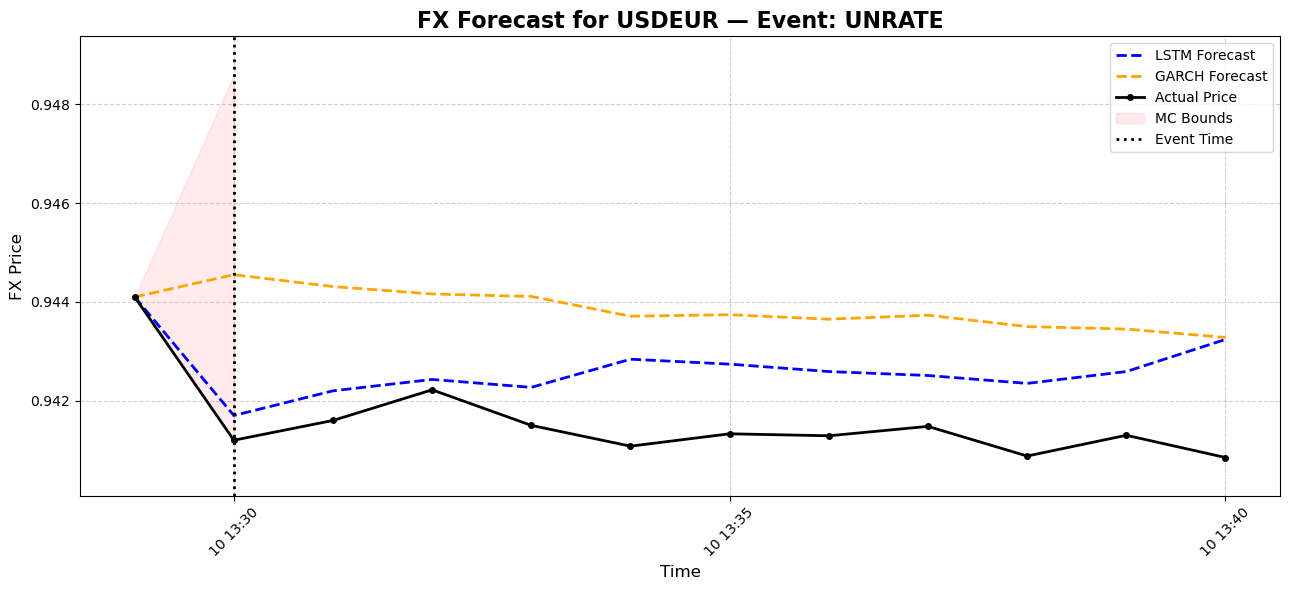

In [35]:
display(combined_df)
plot_fx_forecasts(combined_df, actual_prices)

,FX_Pair,LSTM_Price,GARCH_Price,GARCH_StdDev,MC_Bounds,Ticker,Expected,Actual,Surprise
Datetime,,,,,,,,,
2023-03-10 13:29:00,USDEUR,0.94410,0.94410,0.000000,"(0.9441, 0.9441)",UNRATE,3.4,3.6,0.2
2023-03-10 13:30:00,USDEUR,0.94174,0.94467,0.000934,"(0.9412, 0.9486)",UNRATE,3.4,3.6,0.2
2023-03-10 13:31:00,USDEUR,0.94238,0.94456,0.000850,"(None, None)",UNRATE,3.4,3.6,0.2
2023-03-10 13:32:00,USDEUR,0.94224,0.94480,0.000894,"(None, None)",UNRATE,3.4,3.6,0.2
2023-03-10 13:33:00,USDEUR,0.94225,0.94512,0.001237,"(None, None)",UNRATE,3.4,3.6,0.2
2023-03-10 13:34:00,USDEUR,0.94196,0.94515,0.000930,"(None, None)",UNRATE,3.4,3.6,0.2
2023-03-10 13:35:00,USDEUR,0.94224,0.94546,0.000912,"(None, None)",UNRATE,3.4,3.6,0.2
2023-03-10 13:36:00,USDEUR,0.94296,0.94546,0.001132,"(None, None)",UNRATE,3.4,3.6,0.2
2023-03-10 13:37:00,USDEUR,0.94246,0.94504,0.001102,"(None, None)",UNRATE,3.4,3.6,0.2


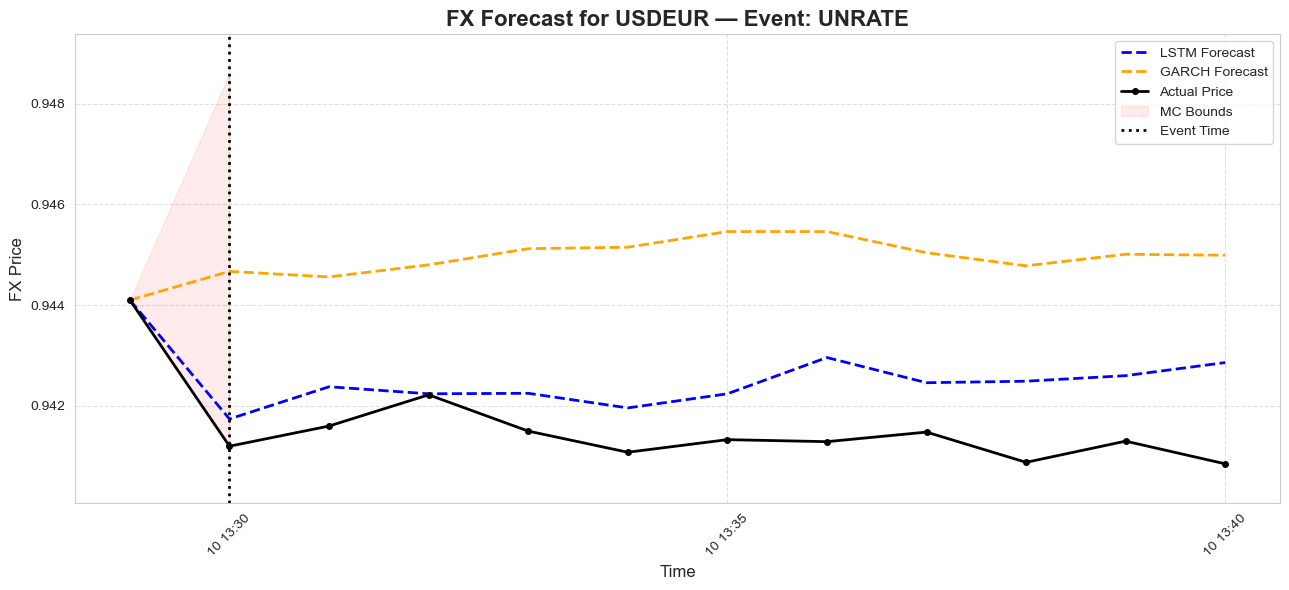

In [79]:
display(combined_df)
plot_fx_forecasts(combined_df, actual_prices)

---

----

1. <span style="color:red">Results and Discusion</span>
    * Interpret market reactions to economic data
2. <span style="color:red">Code Refactoring